<a href="https://colab.research.google.com/github/UN-GCPDS/Curso-Corto-LLMs/blob/main/2.Entrenamiento_Tabnet/Entrenamiento_Tabnet_Parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **Entrenamiento modelo Tabnet**

## **Descripción**

Entrenamiento de modelo Tabnet bajo diversas condiciones.

### **Profesor - Sesión 1:** Andrés Marino Álvarez Meza y Diego Armando Pérez Rosero

# Datos

**TabNet para criticidad en redes de media tensión — Planteamiento y datos (Regresión)**

Sea el conjunto de datos

$$
\mathbf{X}\in\mathbb{R}^{N\times M},\qquad
\mathbf{y}\in\mathbb{R}^{N}.
$$

Cada fila de $\mathbf{X}$ representa un evento o periodo entre 2019 y 2024 y contiene las características de los elementos asociados al equipo que operó. El vector $\mathbf{y}$ almacena el valor continuo del indicador a modelar (SAIDI o SAIFI) para ese mismo evento/periodo.

Definimos

$$
\mathcal{F}:\mathcal{X}\subseteq\mathbb{R}^{M}\to\mathbb{R},\qquad
\hat{y}=\mathcal{F}(\mathbf{x})
=
\bigl(\,\breve{f}_{L}\circ \breve{f}_{L-1}\circ \cdots \circ \breve{f}_{1}\,\bigr)(\mathbf{x}),
$$

donde $\breve{f}_{l}(\cdot)$ denota el $l$-ésimo bloque del modelo ($l\in\{1,\dots,L\}$) y $\circ$ es el operador de composición.

En caso multisalida para $(\text{SAIDI},\text{SAIFI})$, se toma $\mathcal{F}:\mathbb{R}^{M}\to\mathbb{R}^{2}$ y $\mathbf{y}\in\mathbb{R}^{N\times 2}$.
![Logo UNAL CHEC](https://raw.githubusercontent.com/Daprosero/Deep-Convolutional-Generative-Adversarial-Network/refs/heads/master/Mercados%20CHEC.png)

In [ ]:
#@title Librerías
# Instalación de paquetes necesarios
!pip install -q gdown
!pip install openTSNE
!pip install pytorch-tabnet optuna
!pip install wget --quiet

# Importación de librerías necesarias
import optuna
import warnings
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.neighbors import NearestNeighbors
from pytorch_tabnet.tab_model import TabNetRegressor, TabNetClassifier
from pytorch_tabnet.augmentations import RegressionSMOTE
from google.colab import drive
import tensorflow as tf
import tensorflow_probability as tfp
import os
from pathlib import Path
import math
import wget
!gdown --id 1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS -O SuperEventos_Criticidad_AguasAbajo_CODEs.zip
!gdown --id 1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ -O model.zip
!gdown --id 16VIuHLgPGpX4J723Wd48UAPhHivLuUaH -O Data_CHEC.zip

import zipfile
import os

zip_path = "SuperEventos_Criticidad_AguasAbajo_CODEs.zip"
extract_dir = "CHEC"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_path = "model.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_path = "Data_CHEC.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Supresión de warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning)

# Función auxiliar para etiquetas
def get_labels(x: pd.Series) -> pd.Series:
    labels, _ = pd.factorize(x)
    return pd.Series(labels, name=x.name, index=x.index)

# Definición de funciones personalizadas de pérdida
def my_mse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    return torch.mean(mse_loss)
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_var_band(
    df,
    var_token,
    row_index=0,
    hours_back=24,
    col_patterns=None,
    display_name=None,
    units=None,
    event_label="evento reportado",
):
    """
    Grafica una variable climática en una franja de horas hacia atrás.

    Parámetros
    ----------
    df : pd.DataFrame
        Contiene columnas por hora para la variable elegida.
        Ejemplos de nombres soportados automáticamente:
        - 'h0-<var>', 'h1-<var>', ..., 'h24-<var>'
        - '<var>_h0', '<var>_h1', ...
        con separadores '_' o '-'.

    var_token : str
        Nombre base de la variable en los nombres de columna (p.ej. 'wind_gust_spd',
        'air_temp', 'precip'). Debe coincidir con lo que aparece en las columnas.

    row_index : int
        Fila (evento) a graficar.

    hours_back : int
        Cuántas horas hacia atrás mostrar.

    col_patterns : list[str] | None
        Lista de regex opcionales para detectar columnas por hora.
        Si None, se generan automáticamente a partir de var_token.

    display_name : str | None
        Etiqueta legible para el eje Y (p.ej. 'Ráfaga de viento').
        Si None, se usa var_token.

    units : str | None
        Unidades para concatenar en la etiqueta Y (p.ej. 'm/s', '°C', 'mm').

    event_label : str
        Texto para la flecha en la hora 0.
    """
    # --- 1) Preparar patrones de columnas ---
    if col_patterns is None:
        # Permitir '_' o '-' (o espacio) entre partes del var_token
        parts = re.split(r'[_\-\s]+', var_token.strip())
        # Construimos un regex que tolere '_' o '-' entre partes
        # ej: 'wind[_-]?gust[_-]?spd'
        var_regex = r'[_-]?'.join(map(re.escape, parts))

        col_patterns = [
            rf'^h(\d{{1,2}})[-_]?{var_regex}$',   # h0-<var>  o  h0_<var>
            rf'^{var_regex}[-_]?h(\d{{1,2}})$',   # <var>-h0  o  <var>_h0
        ]

    # --- 2) Detectar columnas y mapear a hora ---
    hour_to_col = {}
    for c in df.columns:
        for pat in col_patterns:
            m = re.match(pat, str(c), flags=re.IGNORECASE)
            if m:
                h = int(m.group(1))
                hour_to_col[h] = c
                break

    if not hour_to_col:
        raise ValueError(
            f"No se encontraron columnas con horas para la variable '{var_token}'.\n"
            f"Prueba ajustando 'var_token' o pasando 'col_patterns' personalizados."
        )

    # --- 3) Construir serie horas [0..hours_back] si existen, orden ascendente ---
    hours = [h for h in sorted(hour_to_col.keys()) if 0 <= h <= hours_back]
    vals = np.array(
        [pd.to_numeric(df.loc[df.index[row_index], hour_to_col[h]], errors='coerce') for h in hours],
        dtype=float
    )

    # --- 4) Graficar ---
    fig, ax = plt.subplots(figsize=(10, 5))

    # línea y puntos
    ax.plot(hours, vals, marker='o')

    # invertir eje X para que se vea 24 -> 0
    ax.set_xlim(hours_back, 0)

    # franja sombreada
    ymin = np.nanmin(vals) if np.isfinite(np.nanmin(vals)) else 0.0
    ymax = np.nanmax(vals) if np.isfinite(np.nanmax(vals)) else 1.0
    pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.axvspan(0, hours_back, alpha=0.15)

    # flecha y etiqueta en hora 0
    y0 = vals[hours.index(0)] if 0 in hours else np.nan
    if not np.isfinite(y0):
        y0 = np.nanmedian(vals) if np.isfinite(np.nanmedian(vals)) else (ymin + ymax) / 2.0

    ax.annotate(
        event_label,
        xy=(0, y0),
        xytext=(max(2, min(4, hours_back*0.15)), y0 + (ymax - y0)*0.15),
        arrowprops=dict(arrowstyle="->", lw=1),
        ha='left', va='bottom'
    )

    # etiquetas
    ylab = display_name if display_name else var_token
    if units:
        ylab = f"{ylab} [{units}]"
    ax.set_xlabel("Horas antes del evento")
    ax.set_ylabel(ylab)
    ax.grid(True, alpha=0.3)

    # ticks principales (24, 18, 12, 6, 0) si corresponde
    xticks = [h for h in [hours_back, 18, 12, 6, 0] if 0 <= h <= hours_back]
    ax.set_xticks(xticks)

    plt.tight_layout()
    plt.show()


# --- Ejemplo de uso:
# plot_wind_gust_band(df=tu_dataframe, row_index=0, hours_back=24)

def my_rmse_loss_fn(y_pred, y_true):
    mse_loss = (y_true - y_pred) ** 2
    mean_mse_loss = torch.mean(mse_loss)
    rmse_loss = torch.sqrt(mean_mse_loss)
    return rmse_loss

def my_mae_loss_fn(y_pred, y_true):
    mae_loss = torch.abs(y_true - y_pred)
    return torch.mean(mae_loss)

def my_mape_loss_fn(y_pred, y_true):
    mape_loss = torch.abs((y_true - y_pred) / y_true) * 100
    return torch.mean(mape_loss)

def my_r2_score_fn(y_pred, y_true):
    total_variance = torch.var(y_true, unbiased=False)
    unexplained_variance = torch.mean((y_true - y_pred) ** 2)
    r2_score = 1 - (unexplained_variance / total_variance)
    return 1-r2_score

# Etapa 0: imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
# ==== Librerías ====
import numpy as np
import cupy as cp
import xgboost as xgb

from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.metrics import r2_score as r2_gpu

# Si quieres comparar con CPU para sanity-check:
from sklearn.metrics import r2_score as r2_cpu
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
# ==== Utilidades ====
def to_cpu(a):
    """Convierte CuPy -> NumPy si aplica."""
    try:
        if isinstance(a, cp.ndarray):
            return cp.asnumpy(a)
    except Exception:
        pass
    return a

def metrics_gpu(y_true_cp, y_pred_cp):
    """MAE, RMSE, R2 calculados en GPU (CuPy)."""
    y_true_cp = cp.asarray(y_true_cp)
    y_pred_cp = cp.asarray(y_pred_cp)
    mae  = float(cp.mean(cp.abs(y_true_cp - y_pred_cp)))
    rmse = float(cp.sqrt(cp.mean((y_true_cp - y_pred_cp)**2)))
    ssr  = float(cp.sum((y_true_cp - y_pred_cp)**2))
    sst  = float(cp.sum((y_true_cp - cp.mean(y_true_cp))**2))
    r2   = 1.0 - ssr / sst if sst > 0 else np.nan
    return mae, rmse, r2

def permutation_importance_rf_gpu(model, X_val_cp, y_val_cp, n_repeats=3, max_feats=None, random_state=42):
    """
    Permutation importance en GPU para RF cuML.
    Devuelve importancia por feature (drop medio de R2 en valid).
    Si max_feats no es None, calcula solo para las primeras max_feats columnas (para acelerar).
    """
    rs = cp.random.RandomState(random_state)
    X_val_cp = cp.asarray(X_val_cp)
    y_val_cp = cp.asarray(y_val_cp)

    # R2 base
    y_pred_base = model.predict(X_val_cp)
    _, _, r2_base = metrics_gpu(y_val_cp, y_pred_base)

    n, d = X_val_cp.shape
    d_eval = d if max_feats is None else int(min(max_feats, d))
    importances = cp.zeros(d, dtype=cp.float32)

    for j in range(d_eval):
        drops = []
        for _ in range(n_repeats):
            Xp = X_val_cp.copy()
            idx = rs.permutation(n)
            Xp[:, j] = Xp[idx, j]  # permutar solo la columna j
            y_pred_p = model.predict(Xp)
            _, _, r2_p = metrics_gpu(y_val_cp, y_pred_p)
            drops.append(r2_base - r2_p)
        importances[j] = cp.mean(cp.asarray(drops))

    return importances  # CuPy array
def regression_metrics(y_true, y_pred):
    mae  = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred)**2)))
    ss_res = float(np.sum((y_true - y_pred)**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan
    return mae, rmse, r2
class CustomTabNetRegressor(TabNetRegressor):
    def __init__(self, *args, **kwargs):
        super(CustomTabNetRegressor, self).__init__(*args, **kwargs)

    def forward(self, X):
        output, M_loss = self.network(X)
        output = torch.relu(output)
        return output, M_loss

    def predict(self, X):
        device = next(self.network.parameters()).device
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X = X.to(device)
        with torch.no_grad():
            output, _ = self.forward(X)
        return output.cpu().numpy()
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from tqdm import tqdm
from ast import literal_eval
from pandas.api.types import is_numeric_dtype


import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def make_strat_labels(y_vals, n_bins=3, min_per_class=2):
    """
    Genera etiquetas para estratificar a partir de un objetivo continuo.
    Reduce bins si no hay suficientes muestras por clase.
    """
    y1d = y_vals.reshape(-1)
    for bins in range(n_bins, 1, -1):
        pct = np.linspace(0, 100, bins + 1)[1:-1]
        cuts = np.percentile(y1d, pct)
        if np.any(np.diff(cuts) <= 0):
            continue
        labels = np.digitize(y1d, bins=cuts).astype(int)
        counts = Counter(labels)
        if all(c >= min_per_class for c in counts.values()) and len(counts) > 1:
            return labels
    return None

def stratify_from_df_or_y(df_labels, idx, y_subset, col='NIVEL_C'):
    """Intenta usar df[col] como etiqueta; si falla, usa percentiles en y_subset."""
    try:
        ycat_full = df_labels.loc[:, col].values.astype(int)
        ycat = ycat_full[idx]
        c10 = Counter(ycat)
        if all(v >= 2 for v in c10.values()) and len(c10) > 1:
            return ycat
    except Exception:
        pass
    return make_strat_labels(y_subset[:,0], n_bins=3, min_per_class=2)

def split_subset(X, y, df_labels=None, n_sub=1000, test_size=0.20, seed=42):
    """
    1) Toma un subset aleatorio de tamaño n_sub.
    2) Escala y (MinMax) sobre el subset.
    3) Split train/test con estratificación si es viable.
    4) Split train/valid (20% del train), con re-estratificación si es posible.
    """
    rng = np.random.RandomState(seed)
    n_total = X.shape[0]
    n_sub = min(n_sub, n_total)
    idx_sub = rng.choice(n_total, size=n_sub, replace=False)

    X_sub = X[idx_sub]
    y_sub = y[idx_sub]
    # etiquetas auxiliares para estratificación
    ycat_sub = stratify_from_df_or_y(df_labels, idx_sub, y_sub) if df_labels is not None else make_strat_labels(y_sub[:,0])
    # escalar objetivo en el subset
    scaler = MinMaxScaler()
    y_sub_scaled = scaler.fit_transform(y_sub)

    split_kwargs = dict(test_size=test_size, random_state=seed, shuffle=True)
    if ycat_sub is not None:
        X_tr, X_te, y_tr, y_te, ycat_tr, ycat_te = train_test_split(
            X_sub, y_sub_scaled, ycat_sub, stratify=ycat_sub, **split_kwargs
        )
    else:
        X_tr, X_te, y_tr, y_te = train_test_split(X_sub, y_sub_scaled, **split_kwargs)
        ycat_tr = ycat_te = None

    # Validación (20% del train)
    if ycat_tr is not None:
        y_tr_raw = y_tr[:,0]
        ycat_t = make_strat_labels(y_tr_raw, n_bins=3, min_per_class=2)
        if ycat_t is not None:
            X_tr, X_va, y_tr, y_va, ycat_tr, ycat_va = train_test_split(
                X_tr, y_tr, ycat_tr, test_size=0.20, random_state=seed, stratify=ycat_t
            )
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(
                X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True
            )
            ycat_va = None
    else:
        X_tr, X_va, y_tr, y_va = train_test_split(
            X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True
        )
        ycat_va = None

    # Reporte rápido
    print("Originales (conservados):", X_orig.shape, y_orig.shape)
    print(f"Subset de {n_sub}:", X_sub.shape, y_sub.shape)
    print("Train/Valid/Test:", X_tr.shape, X_va.shape, X_te.shape)
    if ycat_sub is not None:
        print("Distribución clases subset:", Counter(ycat_sub))

    return {
        "idx_sub": idx_sub,
        "X_train": X_tr, "X_valid": X_va, "X_test": X_te,
        "y_train": y_tr, "y_valid": y_va, "y_test": y_te
    }
from copy import deepcopy
from sklearn.metrics import r2_score

def eval_and_print(title, clf_model, X_test, y_test):
    """Evalúa R² en escala original (inverse_transform) y lo imprime."""
    y_pred = clf_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{title}: R2={r2:.4f}")
    return r2

def run_three_training_strategies(
    # modelos / kwargs
    clf_base,                   # modelo ya entrenado en la Fase 1 (con warm_start=True)
    model_init_kwargs,          # dict con los kwargs para construir un modelo nuevo idéntico (desde cero)
    # datos antiguos (Fase 1)
    X_train_old, y_train_old,   # típicamente (X_train, y_train[:,0:1]) de los 1000
    X_test_old, y_test_old,  # test y scaler usados en la Fase 1
    # datos nuevos (Fase 2)
    X_tr_new, y_tr_new,         # train de los 500
    X_va_new, y_va_new,         # valid de los 500 (para early stopping)
    X_te_new, y_te_new,  # test nuevo y su scaler
    # entrenamiento
    batch_size, virtual_batch_size, aug,
    max_epochs_ft_inc=200, patience_ft_inc=70,
    max_epochs_ft_new=200, patience_ft_new=70,
    max_epochs_scratch=200, patience_scratch=70,
    lower_lr_factor=0.1, min_lr=1e-5
):
    """
    Ejecuta:
      A) Fine-tuning incremental (old + new)
      B) Fine-tuning no incremental (solo new)
      C) Desde cero (old + new)
    y evalúa R² en test viejo y test nuevo (ambos en escala original).
    Devuelve un dict con los R².
    """
    results = {}

    # =============================
    # A) Fine-tuning incremental
    # =============================
    clf_ft_inc = deepcopy(clf_base)  # copia del clf ya entrenado
    # bajar LR para fine-tune (opcional, recomendado)
    if hasattr(clf_ft_inc, "_optimizer"):
        for g in clf_ft_inc._optimizer.param_groups:
            g["lr"] = max(g["lr"] * lower_lr_factor, min_lr)

    X_inc = np.concatenate([X_train_old, X_tr_new], axis=0)
    y_inc = np.concatenate([y_train_old, y_tr_new], axis=0)

    clf_ft_inc.fit(
        X_train=X_inc, y_train=y_inc,
        eval_set=[(X_inc, y_inc), (X_va_new, y_va_new)],
        eval_name=['train_inc', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_ft_inc, patience=patience_ft_inc,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Fine-tuning incremental ==")
    r2_old_inc = eval_and_print("Test viejo (FT incremental)", clf_ft_inc, X_test_old, y_test_old)
    r2_new_inc = eval_and_print("Test nuevo (FT incremental)", clf_ft_inc, X_te_new,  y_te_new)
    results["fine_tune_incremental"] = {"R2_old_test": r2_old_inc, "R2_new_test": r2_new_inc, "model": clf_ft_inc}

    # =============================
    # B) Fine-tuning no incremental (solo nuevos)
    # =============================
    clf_ft_new = deepcopy(clf_base)
    if hasattr(clf_ft_new, "_optimizer"):
        for g in clf_ft_new._optimizer.param_groups:
            g["lr"] = max(g["lr"] * lower_lr_factor, min_lr)

    clf_ft_new.fit(
        X_train=X_tr_new, y_train=y_tr_new,
        eval_set=[(X_tr_new, y_tr_new), (X_va_new, y_va_new)],
        eval_name=['train_new', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_ft_new, patience=patience_ft_new,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Fine-tuning NO incremental (solo nuevos) ==")
    r2_old_new = eval_and_print("Test viejo (FT no incremental)", clf_ft_new, X_test_old, y_test_old)
    r2_new_new = eval_and_print("Test nuevo (FT no incremental)", clf_ft_new, X_te_new,  y_te_new)
    results["fine_tune_only_new"] = {"R2_old_test": r2_old_new, "R2_new_test": r2_new_new, "model": clf_ft_new}

    # =============================
    # C) Desde cero (cumulative old+new)
    # =============================
    # model_init_kwargs debe contener todo lo necesario para reconstruir el TabNet
    clf_scratch = CustomTabNetRegressor(**model_init_kwargs)

    X_cum = np.concatenate([X_train_old, X_tr_new], axis=0)
    y_cum = np.concatenate([y_train_old, y_tr_new], axis=0)

    clf_scratch.fit(
        X_train=X_cum, y_train=y_cum,
        eval_set=[(X_cum, y_cum), (X_va_new, y_va_new)],
        eval_name=['train_cum', 'valid_new'],
        eval_metric=['mae'], loss_fn=my_r2_score_fn,
        max_epochs=max_epochs_scratch, patience=patience_scratch,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )

    print("\n== Desempeño: Desde cero (old+new) ==")
    r2_old_sc = eval_and_print("Test viejo (desde cero)", clf_scratch, X_test_old, y_test_old)
    r2_new_sc = eval_and_print("Test nuevo (desde cero)", clf_scratch, X_te_new,  y_te_new)
    results["from_scratch"] = {"R2_old_test": r2_old_sc, "R2_new_test": r2_new_sc, "model": clf_scratch}
    return results
def pick_new_indices(n_new=500, seed=123):
    rng = np.random.RandomState(seed)
    universe = np.setdiff1d(np.arange(X.shape[0]), splits_1000["idx_sub"], assume_unique=True)
    n_new = min(n_new, universe.shape[0])
    return rng.choice(universe, size=n_new, replace=False)
Xdata = df = pd.read_pickle('/content/CHEC/SuperEventos_Criticidad_AguasAbajo_CODEs.pkl')
Xdata = Xdata[Xdata['duracion_h'] <= 100]
# ---------------------------------------------------------
# Etapa 1: seleccionar objetivo (SAIDI o SAIFI) con forma (N,1)
# Extraer variables objetivo
Dur_h = Xdata['duracion_h'].values
SAIDI = Xdata['SAIDI'].values
df1=Xdata.copy()
# Eliminar columnas no utilizadas
Xdata.drop(['inicio_evento', 'h0-solar_rad', 'h0-uv', 'h1-solar_rad', 'h1-uv', 'h2-solar_rad', 'h2-uv', 'h3-solar_rad', 'h3-uv',
            'h4-solar_rad', 'h4-uv', 'h5-solar_rad', 'h5-uv', 'h19-solar_rad', 'h19-uv', 'h20-solar_rad', 'h20-uv',
            'h21-solar_rad', 'h21-uv', 'h22-solar_rad', 'h22-uv', 'h23-solar_rad', 'h23-uv', 'evento', 'fin', 'inicio',
            'cnt_usus', 'DEP', 'MUN', 'FECHA', 'NIVEL_C', 'VALOR_C', 'TRAMOS_AGUAS_ABAJO', 'EQUIPOS_PUNTOS',
            'PUNTOS_POLIGONO', 'LONGITUD2', 'LATITUD2', 'FECHA_C','TRAMOS_AGUAS_ABAJO_CODES','ORDER_'],
           inplace=True, axis=1)

# Definir la variable objetivo y eliminarla del conjunto de características
target = ['SAIFI', 'SAIDI', 'duracion_h']
y1 = Xdata[target].values
Xdata.drop(target, axis=1, inplace=True)
y = y1[:, 0:1].astype('float32')

# Copia de trabajo de X
df = Xdata.copy()

# ---------------------------------------------------------
# Etapa 2: tipificar columnas
NUMERIC_COLUMNS = df.select_dtypes(include=['number']).columns.tolist()
CATEGORICAL_COLUMNS = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ---------------------------------------------------------
# Etapa 3: imputación numérica
max_values = {}
for col in NUMERIC_COLUMNS:
    max_value = pd.to_numeric(df[col], errors='coerce').max()
    if pd.isna(max_value):
        max_value = 0.0
    max_values[col] = max_value
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-10.0 * max_value)

# ---------------------------------------------------------
# Etapa 4: codificación categórica
label_encoders = {}
categorical_dims = {}
for col in CATEGORICAL_COLUMNS:
    enc = LabelEncoder()
    s = df[col].astype(str).fillna("no aplica")
    enc.fit(s)
    df[col] = enc.transform(s)
    label_encoders[col] = enc
    categorical_dims[col] = len(enc.classes_)

# ---------------------------------------------------------
# Etapa 5: construir matrices X, y
unused_feat = []
# Si Xdata NO incluye el target, basta con tomar todas las columnas
features = [c for c in df.columns if c not in unused_feat]
X = df[features].values.astype('float32')


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS
From (redirected): https://drive.google.com/uc?id=1o_fZIhk6ErrtrM3eVZPF9s2qj8l4FoqS&confirm=t&uuid=be8bd5d8-9b06-4fcf-9f09-89d4ef149d5a
To: /content/SuperEventos_Criticidad_AguasAbajo_CODEs.zip
100% 214M/214M [00:02<00:00, 99.1MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ
From (redirected): https://drive.google.com/uc?id=1lBrseLoEmr6-VwNSCHOp2zuc4sKKrkbQ&confirm=t&uuid=343fda9b-a2d9-49cf-a50d-3d8ee5a7

In [ ]:
X.shape,y.shape

# Etapa 6: clases auxiliares para estratificación
try:
    # usar etiqueta externa si existe
    y_categorized = df1['NIVEL_C'].values.astype(int)
except Exception:
    # fallback: terciles del objetivo
    percentiles = np.percentile(y[:, 0], [33.33, 66.66])
    y_categorized = np.digitize(y[:, 0].flatten(), bins=percentiles).astype(int)

# ---------------------------------------------------------
# Etapa 7: escalar objetivo (regresión)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

# ---------------------------------------------------------
# Etapa 8: split train/test estratificado
X_train, X_test, y_train, y_test, ycat_train, ycat_test = train_test_split(
    X, y_scaled, y_categorized, test_size=0.20, random_state=42, stratify=y_categorized
)

# Etapa 8b: split train/valid estratificado por percentiles de y_train
percentiles_t = np.percentile(y_train[:, 0], [25, 50, 75])
y_categorized_t = np.digitize(y_train[:, 0].flatten(), bins=percentiles_t).astype(int)

X_train, X_valid, y_train, y_valid, ycat_train, ycat_valid = train_test_split(
    X_train, y_train, ycat_train, test_size=0.20, random_state=42, stratify=y_categorized_t
)

# Comprobaciones rápidas
print(X.shape, y.shape)
print("Train/Valid/Test:", X_train.shape, X_valid.shape, X_test.shape)

(166323, 312) (166323, 1)
Train/Valid/Test: (106446, 312) (26612, 312) (33265, 312)


![Logo UNAL CHEC](https://catalog.ngc.nvidia.com/_next/image?url=https%3A%2F%2Fassets.nvidiagrid.net%2Fngc%2Flogos%2FOSS-Nvidia-Partnership-Rapids.png&w=828&q=90)


**RAPIDS** es un ecosistema de NVIDIA que replica APIs de *pandas/scikit-learn* en GPU (cuDF, cuML, CuPy), permitiendo ejecutar **preprocesamiento** y **modelos** en la misma memoria de la GPU. Para este proyecto (regresión de SAIDI/SAIFI con millones de filas y decenas–centenas de variables), esto aporta:

* **Aceleración efectiva**: entrenamientos y predicciones con cuML (**RandomForest**) y XGBoost en GPU reducen tiempos de minutos/horas a segundos/minutos (según tamaño del dataset y GPU), facilitando *grid search* y validaciones repetidas.
* **Menos copias CPU↔GPU**: mover $\mathbf{X}$ y $\mathbf{y}$ una sola vez a GPU (CuPy/cuDF) evita cuellos de botella y mantiene el *pipeline* end-to-end en dispositivo.
* **Escalabilidad y memoria**: el *pool* de memoria de **RMM** disminuye la fragmentación y estabiliza cargas grandes, clave en árboles y *boosting*.
* **Compatibilidad**:

  * **cuML** mantiene una interfaz tipo scikit-learn (fit/predict), ideal para **RandomForest** en GPU.
  * **XGBoost** usa `device="cuda"` + `tree_method="hist"` y `DeviceQuantileDMatrix`, optimizando entrenamiento con datos densos y continuos.
* **Reproducibilidad**: fijar semillas y particiones estratificadas mantiene resultados consistentes entre corridas y modelos.


In [ ]:

# ==== Envío de tus datos a GPU ====
# Se asume que ya tienes X_train, X_valid, X_test, y_train, y_valid, y_test definidos en RAM (NumPy/Pandas).
Xtr = cp.asarray(X_train)
Xva = cp.asarray(X_valid)
Xte = cp.asarray(X_test)

# objetivo 1D float32
ytr = cp.asarray(y_train.ravel().astype('float32'))
yva = cp.asarray(y_valid.ravel().astype('float32'))
yte = cp.asarray(y_test.ravel().astype('float32'))

y_train_1d = y_train.ravel().astype('float32')
y_valid_1d = y_valid.ravel().astype('float32')
y_test_1d  = y_test.ravel().astype('float32')

# Nombres de features si existen; si no, genera f0..f{d-1}
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]


## Árboles de decisión y bosques aleatorios

- Los árboles de decisión y los bosques aletorios pertenecen al grupo de algoritmos clásicos más potentes, junto con las máquinas de vectores de soporte.

- Su principio se centra en la generación de fronteras de decisión mediante umbralizaciones sobre las características.

- Un bosque aleatorio se puede entender como un método de ensamble, a partir de la repartición aleatoria de árboles de decisión que actúan en paralelo sobre distintos atributos, y la decisión final se obtiene mediante voto mayoritario o promedio.
![RandomForest](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/randomforest.png?raw=1)





In [ ]:
# Hiperparámetros recomendados (evita el warning de 'rows_sample' no soportado)
rf = cuRF(
    n_estimators=400,       # más ligero que 600
    max_depth=16,          # reduce tiempo/sobreajuste
    max_features=0.7,      # fracción de variables por split
    min_samples_leaf=5,
    min_samples_split=10,
    bootstrap=True,
    n_streams=8,
    random_state=42
)

rf.fit(Xtr, ytr)

# Predicciones
y_pred_val_rf = rf.predict(Xva)
y_pred_te_rf  = rf.predict(Xte)

# Métricas (GPU)
mae_v, rmse_v, r2_v = metrics_gpu(yva, y_pred_val_rf)
mae_t, rmse_t, r2_t = metrics_gpu(yte, y_pred_te_rf)


print(f"[RF cuML] Test  -> R2={r2_t:.4f}  MAE={mae_t:.4f}  RMSE={rmse_t:.4f}")

# (Opcional) comparación con sklearn en CPU para sanity-check
print(f"[RF sklearn] R2 Test (CPU): {r2_cpu(to_cpu(yte), to_cpu(y_pred_te_rf)):.4f}")


[RF cuML] Test  -> R2=0.8709  MAE=0.0008  RMSE=0.0051
[RF sklearn] R2 Test (CPU): 0.8709


## XGBoost (Gradient Boosted Trees)

* XGBoost es una implementación optimizada de *gradient boosting* para árboles de decisión, ampliamente competitiva en datos tabulares por su eficiencia, control de sobreajuste y soporte nativo en GPU.

* Su principio consiste en **aprender de forma aditiva** una suma de árboles que van corrigiendo el error del modelo previo mediante gradientes (de primer y segundo orden) de la función de pérdida, con regularización $L_1/L_2$, tasa de aprendizaje (*shrinkage*), y submuestreo de filas/columnas.

* A diferencia de los bosques aleatorios (árboles en paralelo con voto/promedio), en XGBoost los árboles se **entrenan secuencialmente** y la predicción es la **suma** de sus salidas; además incorpora *early stopping*, manejo explícito de valores faltantes y entrenamiento acelerado con `tree_method="hist"` y `device="cuda"`.

![RandomForest](https://www.researchgate.net/publication/356698772/figure/fig2/AS:1096436418641951@1638422221975/The-architecture-of-Gradient-Boosting-Decision-Tree.png)


[XGB GPU] Test  -> R2=0.8861


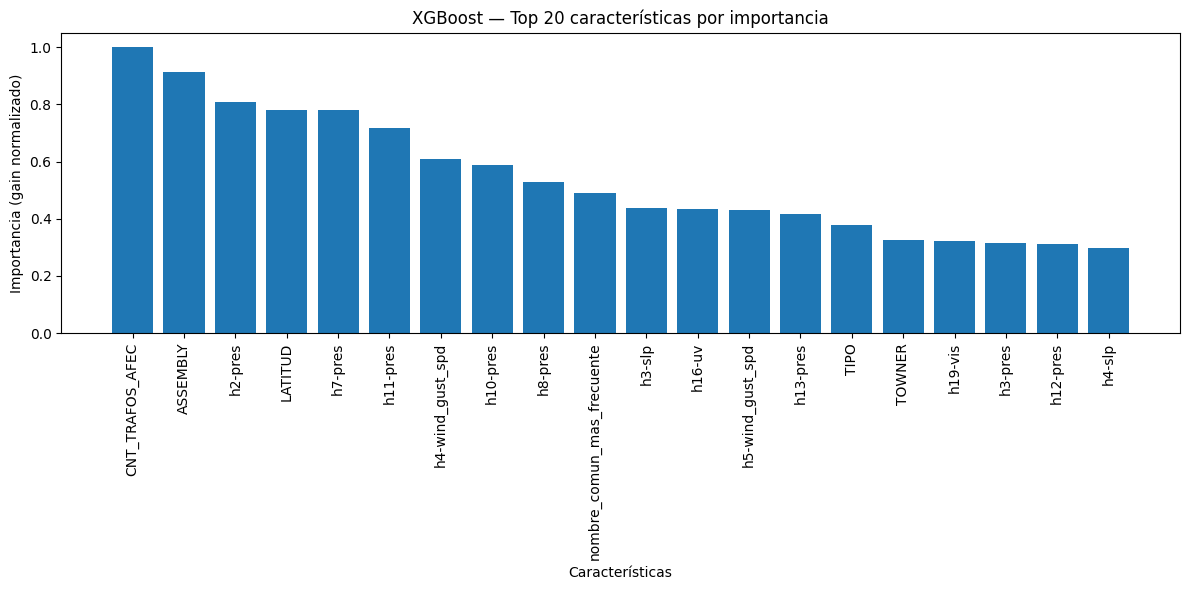

In [ ]:
dtrain = xgb.DMatrix(Xtr, label=y_train_1d)
dvalid = xgb.DMatrix(Xva, label=y_valid_1d)
dtest  = xgb.DMatrix(Xte,  label=y_test_1d)

# Parámetros XGBoost para regresión en GPU
params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",   # <- ya no 'gpu_hist'
    "device": "cuda",        # <- activa GPU
    "max_depth": 8,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "alpha": 0.0,
    "random_state": 42,
    "eval_metric": "rmse",
    "verbosity": 0           # <- silencia logs internos de XGB
}

num_boost_round = 3000
early_stopping_rounds = 100

watchlist = [(dtrain, "train"), (dvalid, "valid")]
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=0
)

# Predicciones con el mejor número de iteraciones
y_pred_valid = booster.predict(dvalid, iteration_range=(0, booster.best_iteration+1))
y_pred_test  = booster.predict(dtest,  iteration_range=(0, booster.best_iteration+1))

r2_v = regression_metrics(y_valid_1d, y_pred_valid)[2]
r2_t = regression_metrics(y_test_1d,  y_pred_test)[2]

print(f"[XGB GPU] Test  -> R2={r2_t:.4f}")
# Obtener nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(X_train.shape[1])]

# Importancias por ganancia
imp = booster.get_score(importance_type="gain")  # {'f0':..., 'f12':...}
scores = np.zeros(len(feature_names), dtype=np.float32)
for k, v in imp.items():
    if k.startswith('f'):
        idx = int(k[1:])  # 'f10' -> 10
        if 0 <= idx < scores.size:
            scores[idx] = v

# Fallback si 'gain' está vacío
if not np.any(scores):
    imp = booster.get_score(importance_type="weight")
    for k, v in imp.items():
        if k.startswith('f'):
            idx = int(k[1:])
            if 0 <= idx < scores.size:
                scores[idx] = v

# Normalizar para una escala [0,1] legible
if scores.max() > 0:
    scores = scores / scores.max()

# Seleccionar Top-20
TOPK = 20
order = np.argsort(scores)[::-1][:TOPK]
top_names = [feature_names[i] for i in order]
top_scores = scores[order]

# Gráfico de barras (vertical), eje x con nombres rotados 90°
plt.figure(figsize=(12, 6))
plt.bar(range(TOPK), top_scores)
plt.xticks(range(TOPK), top_names, rotation=90)
plt.ylabel("Importancia (gain normalizado)")
plt.xlabel("Características")
plt.title("XGBoost — Top 20 características por importancia")
plt.tight_layout()
plt.show()

## TabNet (Attentive Neural Networks for Tabular Data)




* TabNet es un modelo de *deep learning* para datos tabulares que combina **atención secuencial** y **selección esparsa de variables**, logrando buen rendimiento en regresión/clasificación con interpretabilidad nativa y entrenamiento en GPU (PyTorch/TF).

* Su principio consiste en **decisiones en pasos**: en cada paso $t$, un *attentive transformer* produce una máscara $\mathbf{M}^{(t)}$ (vía *sparsemax*) que **selecciona un subconjunto de características**; un *decision transformer* procesa solo esas columnas y genera una contribución. Las salidas de todos los pasos se **agregan aditivamente** para la predicción, mientras una regularización de **esparsidad** limita el número de variables usadas y controla su reuso ($\gamma$).

* A diferencia de los ensambles de árboles, TabNet **aprende representaciones no lineales** y **selección de variables dependiente del contexto** en un solo modelo end-to-end; además, ofrece **importancias globales** (promedio de máscaras) y **explicaciones locales** por muestra, maneja variables categóricas mediante **embeddings**, soporta *early stopping* y *mini-batches*, y se beneficia de la aceleración en GPU para grandes volúmenes de datos.

![RandomForest](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*XWoroyIDVa_ACzcKmigwOQ.png)

In [ ]:
clf = torch.load("/content/CHEC/model.pth",weights_only=False)

y_pred=clf.predict(X_test)
y_pred_=np.tile(y_pred, (1, 2))
y_pred_ = scaler.inverse_transform(y_pred_)
y_test_ = scaler.inverse_transform(y_test)
# Plot 2
r2_1 = r2_score(y_test_[:, 0], y_pred_[:, 0])
print(f" Test  -> R2={r2_1:.4f}")

 Test  -> R2=0.8832


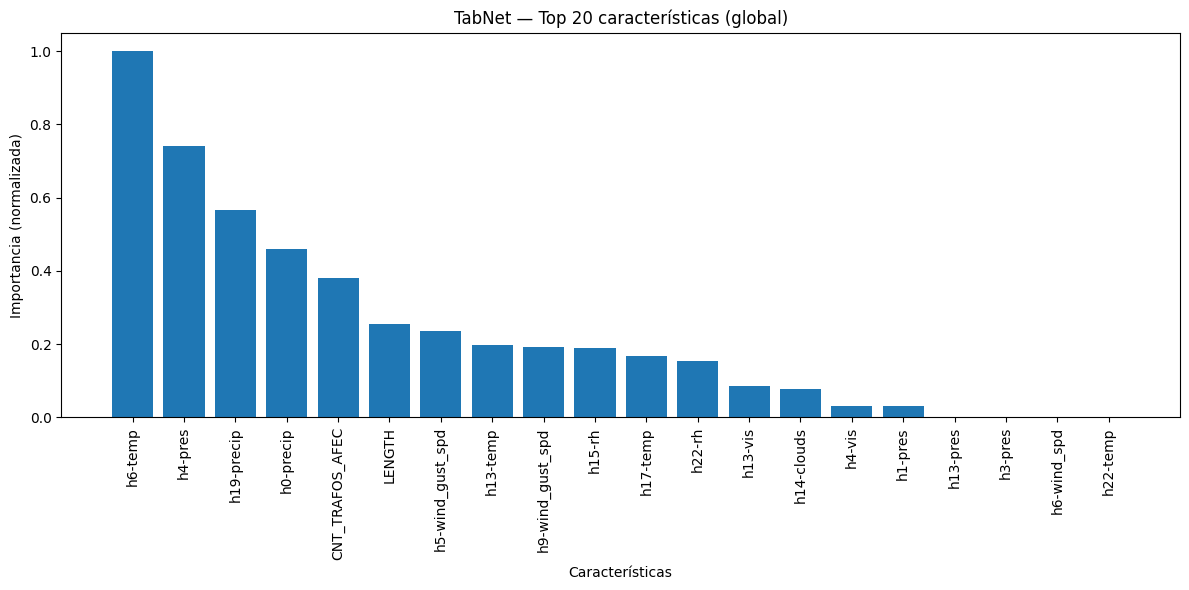

In [ ]:

# Importancias globales del modelo (promedio de máscaras de atención)
imp = getattr(clf, "feature_importances_", None)
if imp is None:
    raise ValueError("clf.feature_importances_ no está disponible; entrena el modelo antes de graficar.")

imp = np.asarray(imp, dtype=float)

# Nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(len(imp))]

# Normalizar a [0, 1] para lectura
imp_norm = imp / imp.max() if imp.max() > 0 else imp

# Top-20
TOPK = 20
order = np.argsort(imp_norm)[::-1][:TOPK]
top_names = [feature_names[i] for i in order]
top_scores = imp_norm[order]

# Gráfico de barras (como la primera gráfica)
plt.figure(figsize=(12, 6))
plt.bar(range(TOPK), top_scores)
plt.xticks(range(TOPK), top_names, rotation=90)
plt.ylabel("Importancia (normalizada)")
plt.xlabel("Características")
plt.title("TabNet — Top 20 características (global)")
plt.tight_layout()
plt.show()


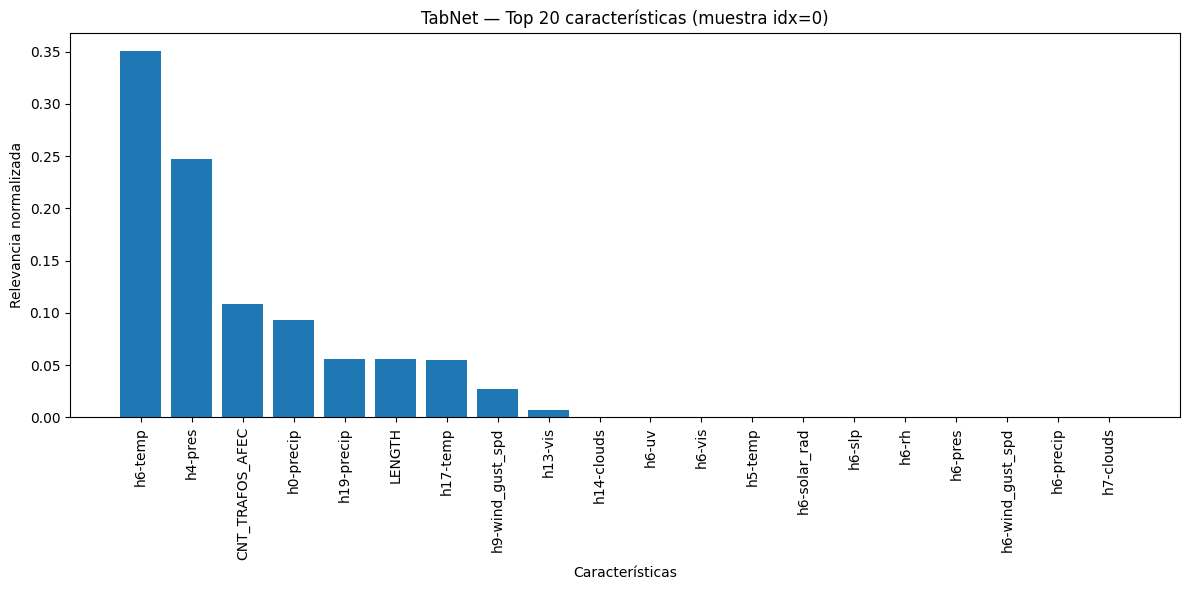

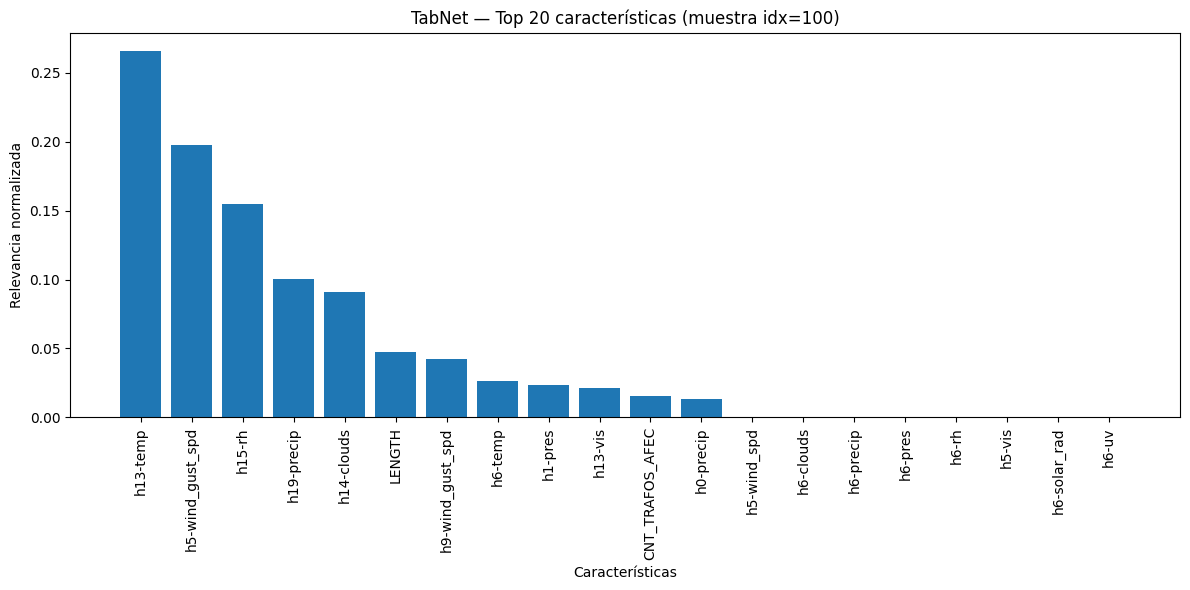

In [ ]:
# Relevancia local por muestra con TabNet (pytorch-tabnet)
# Se asume que tienes un TabNetRegressor entrenado llamado `clf`
# y una lista `features` con los nombres de columnas en el mismo orden que X_*.

# 1) Selecciona algunas muestras (por índice sobre X_test)
idx = [0,100]  # cámbialos por las filas que te interesen
X_samples = X_test[idx]

# 2) Explicaciones locales
# M_explain: (n_muestras, n_features)
# masks: lista de largo n_steps con matrices (n_muestras, n_features) por paso
M_explain, masks = clf.explain(X_samples)

# 3) Normaliza por fila para leer como “peso relativo” (opcional pero útil)
M_norm = M_explain / (M_explain.sum(axis=1, keepdims=True) + 1e-12)

# 4) Nombres de features
try:
    feature_names = list(features)
except NameError:
    feature_names = [f"f{i}" for i in range(M_norm.shape[1])]

TOPK = 20

# 5) Gráfico por muestra (una figura por muestra, barras con rotación 90°)
for r, row in enumerate(M_norm):
    order = np.argsort(row)[::-1][:TOPK]
    names = [feature_names[i] for i in order]
    scores = row[order]
    plt.figure(figsize=(12, 6))
    plt.bar(range(TOPK), scores)
    plt.xticks(range(TOPK), names, rotation=90)
    plt.ylabel("Relevancia normalizada")
    plt.xlabel("Características")
    plt.title(f"TabNet — Top {TOPK} características (muestra idx={idx[r]})")
    plt.tight_layout()
    plt.show()


# TabNet: fundamentos matemáticos



![Logo UNAL CHEC](https://ars.els-cdn.com/content/image/1-s2.0-S2590123025027392-gr002.jpg)

| **Ecuación** | **Explicación práctica** |
|--------------|---------------------------|
| $$\hat{y} = f(X|\theta) = (N_{\text{steps}} \circ N_{\text{steps-1}} \circ \cdots \circ N_1)(X)$$ | La predicción final se construye aplicando secuencialmente varios bloques de decisión. |
| $$a^i = \text{sparsemax}(P^{i-1} \odot h_i(a^{i-1}))$$ | En cada paso, el modelo aplica una máscara que selecciona solo algunas variables importantes. |
| $$P^i[j] = \sum_{j=1}^{i} \frac{1}{\gamma} \big(M^i[j]\big)$$ | Se controla cuántas veces se ha usado cada variable para no repetir siempre las mismas. |
| $$[d[i], a[i]] = \mathcal{F}(M^i \odot X)$$ | Las variables seleccionadas pasan por un transformador que genera nuevas representaciones útiles. |
| $$GLU(h) = (W_h h + b) \odot \sigma(W_g h + b_g)$$ | Módulos tipo “puerta” que deciden qué información pasa y cuál se bloquea. |
| $$\hat{X} = \frac{X - \mu_{B_v}}{\sqrt{\sigma^2_{B_v} + \epsilon}}$$ | Normalización por mini-lotes virtuales para estabilizar el entrenamiento. |
| $$d_{\text{out}} = \sum_{i=1}^{N_{\text{steps}}} \text{ReLU}(d[i])$$ | Se suman las contribuciones de todos los pasos de decisión. |
| $$\hat{y} = W_{\text{final}} \cdot d_{\text{out}}$$ | El vector combinado se transforma en la predicción final. |
| $$\mathcal{L}_{\text{task}} = \tfrac{1}{B} \sum_{i=1}^{B} \| y_i - \hat{y}_i \|^2$$ | Error cuadrático medio: compara valores reales y predichos. |
| $$\mathcal{L}_{\text{sparse}} = \sum_{i=1}^{N_{\text{steps}}} \sum_{j=1}^{B} \sum_{p=1}^{D} M^i_{jp} \log(M^i_{jp} + \epsilon)$$ | Penaliza cuando se usan demasiadas variables, fomentando interpretabilidad. |
| $$\mathcal{L} = \mathcal{L}_{\text{task}} + \lambda_{\text{sparse}} \mathcal{L}_{\text{sparse}}$$ | Pérdida total = error de predicción + penalización por esparsidad. |
| $$M_{\text{agg}}^j = \sum_{i=1}^{N_{\text{steps}}} \tfrac{1}{B} \sum_{b=1}^{B} M^i_{b,j} \cdot \text{Imp}_i$$ | Se calcula la importancia global de cada variable sumando las máscaras de todos los pasos. |

---

Este esquema muestra cómo TabNet combina:  
1. **Selección secuencial de variables** (máscaras).  
2. **Transformaciones controladas** (GLU, normalización).  
3. **Predicción final regulada** (pérdida con sparsidad).  
4. **Interpretabilidad** (importancia global de las variables).  





## Hiperparámetros propios de TabNet



- **n_d (dimensión de decisión)** y **n_a (dimensión de atención):**  
  Pueden entenderse como la capacidad del modelo para "pensar" y "mirar".  
  - `n_d` es como el tamaño de la libreta donde el modelo escribe lo aprendido para predecir.  
  - `n_a` es como el tamaño de los lentes con los que el modelo observa las variables.  
  Valores más grandes permiten procesar información con más detalle, pero hacen el modelo más complejo y lento.

- **n_steps (número de pasos de decisión):**  
  Indica cuántas veces el modelo analiza la información antes de dar una respuesta.  
  Más pasos equivalen a revisar los datos con mayor profundidad.

- **gamma:**  
  Regula cuánto busca el modelo nuevas variables en cada paso.  
  Un gamma alto implica mayor exploración, mientras que un gamma bajo concentra la atención en lo ya encontrado.

- **lambda_sparse:**  
  Controla cuántas variables se seleccionan en cada paso.  
  Valores altos fuerzan al modelo a enfocarse en pocas variables (más interpretabilidad),  
  mientras que valores bajos permiten considerar más variables (más flexibilidad).

- **batch_size:**  
  Define cuántas filas del conjunto de datos se procesan al mismo tiempo durante el entrenamiento.  
  Batches grandes aceleran el entrenamiento pero requieren más memoria.


- **emb (embedding para variables categóricas):**  
  Convierte las categorías en vectores numéricos que capturan mejor la información.  
  Un tamaño mayor de embedding permite representaciones más ricas, aunque con mayor costo computacional.

- **virtual_batch_size:**  
  Subdivisión interna del batch, utilizada para estabilizar el entrenamiento mediante  
  la técnica llamada *Ghost Batch Normalization*.  
  Sirve para que los cálculos estadísticos de normalización sean más estables incluso con batches grandes.

---

En conjunto, estos hiperparámetros permiten balancear tres aspectos clave:  
1. **Capacidad predictiva** (precisión del modelo).  
2. **Eficiencia computacional** (tiempo y recursos de entrenamiento).  
3. **Interpretabilidad** (capacidad de explicar qué variables fueron importantes).  

In [ ]:
X_orig = X.copy()
y_orig = y.copy()

In [ ]:
# =========================
# Custom TabNet + Objective
# =========================
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

class CustomTabNetRegressor(TabNetRegressor):
    def __init__(self, *args, **kwargs):
        super(CustomTabNetRegressor, self).__init__(*args, **kwargs)
    def forward(self, X):
        output, M_loss = self.network(X)
        output = torch.relu(output)
        return output, M_loss
    def predict(self, X):
        device = next(self.network.parameters()).device
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32)
        X = X.to(device)
        with torch.no_grad():
            output, _ = self.forward(X)
        return output.cpu().numpy()

# ---- prepara el subset de 1000 para HPO ----
splits_1000 = split_subset(X, y, df_labels=df1, n_sub=1000, test_size=0.20, seed=42)
X_train, X_valid = splits_1000["X_train"], splits_1000["X_valid"]
y_train, y_valid = splits_1000["y_train"], splits_1000["y_valid"]
X_test,  y_test  = splits_1000["X_test"],  splits_1000["y_test"]

# Supone que ya tienes:
# - features, CATEGORICAL_COLUMNS, categorical_dims
# - RegressionSMOTE, my_r2_score_fn, optuna importados

def make_tabnet(cat_info, params):
    cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]
    cat_dims = [categorical_dims[f] for f in features if f in CATEGORICAL_COLUMNS]
    cat_emb_dim = [min(params['emb'], max(4, (dim + 1)//2)) for dim in cat_dims]
    return cat_idxs, cat_dims, cat_emb_dim

def build_optimizer(optimizer_type, learning_rate, momentum, weight_decay):
    if optimizer_type == 'adam':
        return torch.optim.Adam, {'lr': float(min(max(learning_rate, 1e-4), 3e-3)), 'weight_decay': weight_decay}
    if optimizer_type == 'adamw':
        return torch.optim.AdamW, {'lr': float(min(max(learning_rate, 1e-4), 3e-3)), 'weight_decay': weight_decay}
    if optimizer_type == 'sgd':
        return torch.optim.SGD, {'lr': float(min(max(learning_rate, 1e-3), 1e-1)), 'momentum': momentum, 'weight_decay': weight_decay}
    if optimizer_type == 'rmsprop':
        return torch.optim.RMSprop, {'lr': float(min(max(learning_rate, 1e-4), 3e-3)), 'momentum': momentum, 'weight_decay': weight_decay}

def objective_regression(trial):
    # Capacidad TabNet
    n_d     = trial.suggest_int('n_d', 8, 32)
    n_a     = trial.suggest_int('n_a', 8, 32)
    n_steps = trial.suggest_int('n_steps', 3, 5)

    gamma         = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True)

    batch_size  = trial.suggest_categorical('batch_size', [64, 128, 256])
    mask_type   = trial.suggest_categorical('mask_type', ['entmax', 'sparsemax'])
    emb         = trial.suggest_int('emb', 4, 24)

    momentum      = trial.suggest_float('momentum', 0.5, 0.95)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
    weight_decay  = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)

    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.95, 0.995)
    step_size       = trial.suggest_int('step_size', 5, 15)

    virtual_batch_size = trial.suggest_categorical('virtual_batch_size', [32, 64])
    if isinstance(batch_size, int) and isinstance(virtual_batch_size, int) and virtual_batch_size > batch_size:
        virtual_batch_size = batch_size // 2 if batch_size >= 64 else batch_size

    optimizer_type = trial.suggest_categorical('optimizer_type', ['adam', 'adamw', 'sgd', 'rmsprop'])
    optimizer_fn, optimizer_params = build_optimizer(optimizer_type, learning_rate, momentum, weight_decay)

    p   = trial.suggest_float('p', 0.0, 0.30)
    aug = RegressionSMOTE(p=p)

    cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]
    cat_dims = [categorical_dims[f] for f in features if f in CATEGORICAL_COLUMNS]
    cat_emb_dim = [min(emb, max(4, (dim + 1)//2)) for dim in cat_dims]

    model = CustomTabNetRegressor(
        cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs,
        n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse,
        mask_type=mask_type, optimizer_fn=optimizer_fn, optimizer_params=optimizer_params,
        scheduler_params={"gamma": scheduler_gamma, "step_size": step_size},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, verbose=True
    )
    model.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['mae'],
        loss_fn=my_r2_score_fn,  # (conserva tu lógica)
        max_epochs=100, patience=40,
        batch_size=batch_size, virtual_batch_size=virtual_batch_size,
        num_workers=1, drop_last=False, augmentations=aug,
    )
    mae = model.history['loss'][-1]
    return mae


Originales (conservados): (166323, 312) (166323, 1)
Subset de 1000: (1000, 312) (1000, 1)
Train/Valid/Test: (640, 312) (160, 312) (200, 312)
Distribución clases subset: Counter({np.int64(2): 265, np.int64(1): 251, np.int64(3): 249, np.int64(0): 235})


## Búsqueda de hiperparámetros




![Logo UNAL CHEC](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*lu62RCEko0VYe-YZ)
**Objetivo:** encontrar combinaciones de hiperparámetros que minimicen una métrica de validación (p. ej., MAE, RMSE, 1–R²) bajo un protocolo de evaluación (holdout/K-fold).

---

#### 1) Grid Search (búsqueda exhaustiva)

* **Idea:** evalúa **todas** las combinaciones de un **grid** predefinido.
* **Ventajas:** sistemático; fácil de reproducir y explicar; bueno en espacios **pequeños**.
* **Desventajas:** costo **exponencial** con el número de hiperparámetros; ineficiente si muchos valores son malos.
* **Cuándo usar:** pocos hiperparámetros y rangos **acotados**; validación de resultados “finales”.

---

#### 2) Random Search (búsqueda aleatoria)

* **Idea:** toma **muestras aleatorias** de distribuciones definidas para cada hiperparámetro.
* **Ventajas:** explora **mejor** espacios grandes con el mismo presupuesto; rápido de configurar.
* **Desventajas:** no usa **información** de pruebas previas; puede omitir regiones prometedoras por azar.
* **Cuándo usar:** presupuestos limitados; muchos hiperparámetros con rangos amplios; etapa **exploratoria** inicial.

---

#### 3) Optimización Bayesiana (p. ej., TPE, GP-BO)

* **Idea:** construye un **modelo sustituto** del desempeño $f(\theta)$ y elige el siguiente punto maximizando una **función de adquisición** (p. ej., *Expected Improvement*).
* **Ventajas:** usa el **historial** para balancear *exploración*/*explotación*; suele requerir **menos** evaluaciones para llegar a buenos resultados.
* **Desventajas:** mayor **complejidad**; sensibilidad a la configuración (modelo, adquisición); coste extra de ajuste del sustituto.
* **Cuándo usar:** evaluación costosa; espacios **medianos/grandes**; se busca **eficiencia** con presupuesto fijo.


In [ ]:
import optuna
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective_regression, n_trials=15)

print("Best hyperparameters for regression: ", study.best_params)
print("Best mae: ", study.best_value)
par = study.best_params


[I 2025-09-05 00:58:05,390] A new study created in memory with name: no-name-55bd5b58-0703-4bc9-927f-5a0e164cfba4
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 31.88583| train_mae: 1.4373  | valid_mae: 1.57791 |  0:00:01s
epoch 1  | loss: 32.36552| train_mae: 0.92973 | valid_mae: 0.93015 |  0:00:01s
epoch 2  | loss: 24.83098| train_mae: 0.7759  | valid_mae: 0.66527 |  0:00:02s
epoch 3  | loss: 25.27773| train_mae: 0.72873 | valid_mae: 0.58456 |  0:00:03s
epoch 4  | loss: 23.23252| train_mae: 0.75707 | valid_mae: 0.6061  |  0:00:04s
epoch 5  | loss: 21.33306| train_mae: 0.77684 | valid_mae: 0.60856 |  0:00:05s
epoch 6  | loss: 20.49553| train_mae: 0.59813 | valid_mae: 0.49186 |  0:00:06s
epoch 7  | loss: 18.71511| train_mae: 0.51733 | valid_mae: 0.52666 |  0:00:06s
epoch 8  | loss: 21.67417| train_mae: 0.43976 | valid_mae: 0.42323 |  0:00:07s
epoch 9  | loss: 22.39866| train_mae: 0.43309 | valid_mae: 0.45107 |  0:00:07s
epoch 10 | loss: 13.7614 | train_mae: 0.3636  | valid_mae: 0.38149 |  0:00:08s
epoch 11 | loss: 15.77027| train_mae: 0.35347 | valid_mae: 0.30581 |  0:00:09s
epoch 12 | loss: 12.66591| train_mae: 0.3759  | vali

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 00:59:25,956] Trial 0 finished with value: 0.9738839268684387 and parameters: {'n_d': 8, 'n_a': 13, 'n_steps': 4, 'gamma': 1.6853392806353038, 'lambda_sparse': 1.0928132847713737e-06, 'batch_size': 256, 'mask_type': 'sparsemax', 'emb': 20, 'momentum': 0.9047649761929001, 'learning_rate': 0.0022449312065940083, 'weight_decay': 6.160794864301858e-06, 'scheduler_gamma': 0.9813016634410717, 'step_size': 12, 'virtual_batch_size': 64, 'optimizer_type': 'adamw', 'p': 0.2728982184483242}. Best is trial 0 with value: 0.9738839268684387.


epoch 99 | loss: 0.97388 | train_mae: 0.03286 | valid_mae: 0.03153 |  0:01:10s
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_mae = 0.02837


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 529.32442| train_mae: 4.84413 | valid_mae: 4.92422 |  0:00:00s
epoch 1  | loss: 434.27403| train_mae: 1.88573 | valid_mae: 1.91856 |  0:00:01s
epoch 2  | loss: 314.46213| train_mae: 1.28585 | valid_mae: 1.3629  |  0:00:02s
epoch 3  | loss: 194.56678| train_mae: 1.30501 | valid_mae: 1.24101 |  0:00:03s
epoch 4  | loss: 286.26581| train_mae: 1.17294 | valid_mae: 1.22351 |  0:00:04s
epoch 5  | loss: 171.85439| train_mae: 1.11649 | valid_mae: 1.04918 |  0:00:05s
epoch 6  | loss: 234.70943| train_mae: 1.23845 | valid_mae: 1.21944 |  0:00:06s
epoch 7  | loss: 366.25521| train_mae: 1.0973  | valid_mae: 1.10429 |  0:00:07s
epoch 8  | loss: 135.96989| train_mae: 1.01414 | valid_mae: 1.11073 |  0:00:08s
epoch 9  | loss: 155.94174| train_mae: 1.04943 | valid_mae: 1.03474 |  0:00:10s
epoch 10 | loss: 199.35704| train_mae: 0.97972 | valid_mae: 0.97763 |  0:00:11s
epoch 11 | loss: 115.17115| train_mae: 0.9338  | valid_mae: 1.13595 |  0:00:12s
epoch 12 | loss: 232.06324| train_mae: 0

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:01:11,106] Trial 1 finished with value: 60.1961464881897 and parameters: {'n_d': 17, 'n_a': 22, 'n_steps': 3, 'gamma': 1.279047079780749, 'lambda_sparse': 9.335282202424502e-05, 'batch_size': 64, 'mask_type': 'sparsemax', 'emb': 12, 'momentum': 0.5834587488113198, 'learning_rate': 0.00024243851017301097, 'weight_decay': 1.9377512841942382e-05, 'scheduler_gamma': 0.9744217724711142, 'step_size': 10, 'virtual_batch_size': 32, 'optimizer_type': 'adamw', 'p': 0.06307793360530106}. Best is trial 0 with value: 0.9738839268684387.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 74.15213| train_mae: 6.2236  | valid_mae: 5.7787  |  0:00:00s
epoch 1  | loss: 78.30111| train_mae: 1.05345 | valid_mae: 1.03107 |  0:00:01s
epoch 2  | loss: 95.82647| train_mae: 0.90368 | valid_mae: 0.8548  |  0:00:02s
epoch 3  | loss: 84.24873| train_mae: 1.23722 | valid_mae: 1.35802 |  0:00:03s
epoch 4  | loss: 59.93914| train_mae: 1.09827 | valid_mae: 1.49122 |  0:00:04s
epoch 5  | loss: 74.60342| train_mae: 1.35651 | valid_mae: 1.42501 |  0:00:04s
epoch 6  | loss: 74.10597| train_mae: 1.71911 | valid_mae: 1.75235 |  0:00:05s
epoch 7  | loss: 77.91185| train_mae: 1.78813 | valid_mae: 2.18661 |  0:00:06s
epoch 8  | loss: 64.73233| train_mae: 1.80369 | valid_mae: 2.57896 |  0:00:06s
epoch 9  | loss: 74.77361| train_mae: 2.55215 | valid_mae: 3.4028  |  0:00:07s
epoch 10 | loss: 51.36455| train_mae: 2.91401 | valid_mae: 3.40027 |  0:00:08s
epoch 11 | loss: 66.40853| train_mae: 2.42081 | valid_mae: 2.79136 |  0:00:09s
epoch 12 | loss: 54.42372| train_mae: 2.62093 | vali

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:02:32,443] Trial 2 finished with value: 4.936153697967529 and parameters: {'n_d': 8, 'n_a': 12, 'n_steps': 5, 'gamma': 1.4316795677301206, 'lambda_sparse': 3.2485218626779113e-05, 'batch_size': 256, 'mask_type': 'entmax', 'emb': 6, 'momentum': 0.9467559134402905, 'learning_rate': 0.0011826041257479401, 'weight_decay': 4.518611248024321e-06, 'scheduler_gamma': 0.9756649455693126, 'step_size': 5, 'virtual_batch_size': 32, 'optimizer_type': 'adam', 'p': 0.08822131660935402}. Best is trial 0 with value: 0.9738839268684387.


epoch 99 | loss: 4.93615 | train_mae: 0.07298 | valid_mae: 0.0705  |  0:01:18s
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_mae = 0.0699


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 609.0941| train_mae: 6.66176 | valid_mae: 8.71244 |  0:00:00s
epoch 1  | loss: 381.23792| train_mae: 4.54399 | valid_mae: 4.14481 |  0:00:01s
epoch 2  | loss: 579.53526| train_mae: 3.39494 | valid_mae: 3.33356 |  0:00:02s
epoch 3  | loss: 495.69136| train_mae: 2.86887 | valid_mae: 2.92078 |  0:00:03s
epoch 4  | loss: 369.47667| train_mae: 2.30602 | valid_mae: 2.09243 |  0:00:04s
epoch 5  | loss: 317.84471| train_mae: 2.63731 | valid_mae: 2.61594 |  0:00:05s
epoch 6  | loss: 310.97735| train_mae: 2.96057 | valid_mae: 3.15197 |  0:00:06s
epoch 7  | loss: 550.63432| train_mae: 2.68025 | valid_mae: 3.10458 |  0:00:07s
epoch 8  | loss: 638.97012| train_mae: 2.97397 | valid_mae: 3.46706 |  0:00:08s
epoch 9  | loss: 235.24534| train_mae: 3.00919 | valid_mae: 3.05993 |  0:00:09s
epoch 10 | loss: 158.8979| train_mae: 2.99379 | valid_mae: 3.21097 |  0:00:10s
epoch 11 | loss: 238.98396| train_mae: 3.03426 | valid_mae: 2.79092 |  0:00:11s
epoch 12 | loss: 147.84565| train_mae: 2.7

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:04:07,523] Trial 3 finished with value: 1.194831085205078 and parameters: {'n_d': 28, 'n_a': 27, 'n_steps': 5, 'gamma': 1.2495920381949346, 'lambda_sparse': 0.0009250338708854, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 7, 'momentum': 0.6857381061431107, 'learning_rate': 0.034190280227121395, 'weight_decay': 4.690039315714738e-06, 'scheduler_gamma': 0.9565161090657542, 'step_size': 13, 'virtual_batch_size': 32, 'optimizer_type': 'adamw', 'p': 0.1543181299843592}. Best is trial 0 with value: 0.9738839268684387.


epoch 99 | loss: 1.19483 | train_mae: 0.03837 | valid_mae: 0.04316 |  0:01:32s
Stop training because you reached max_epochs = 100 with best_epoch = 75 and best_valid_mae = 0.03336


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 962.46525| train_mae: 6.68152 | valid_mae: 8.43294 |  0:00:00s
epoch 1  | loss: 486.95857| train_mae: 3.65691 | valid_mae: 3.97851 |  0:00:01s
epoch 2  | loss: 366.68249| train_mae: 2.87012 | valid_mae: 2.74586 |  0:00:02s
epoch 3  | loss: 275.65892| train_mae: 3.41702 | valid_mae: 3.57654 |  0:00:03s
epoch 4  | loss: 220.21466| train_mae: 2.51612 | valid_mae: 2.54628 |  0:00:04s
epoch 5  | loss: 236.5451| train_mae: 1.84592 | valid_mae: 2.07188 |  0:00:05s
epoch 6  | loss: 288.76661| train_mae: 2.05965 | valid_mae: 1.92918 |  0:00:06s
epoch 7  | loss: 217.16182| train_mae: 1.75842 | valid_mae: 2.20854 |  0:00:06s
epoch 8  | loss: 179.72555| train_mae: 1.7915  | valid_mae: 1.44215 |  0:00:07s
epoch 9  | loss: 151.61989| train_mae: 1.87635 | valid_mae: 1.9799  |  0:00:08s
epoch 10 | loss: 167.93586| train_mae: 1.60824 | valid_mae: 2.16505 |  0:00:09s
epoch 11 | loss: 202.62447| train_mae: 1.49691 | valid_mae: 1.94063 |  0:00:09s
epoch 12 | loss: 168.4035| train_mae: 1.5

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:05:30,503] Trial 4 finished with value: 22.55940475463867 and parameters: {'n_d': 29, 'n_a': 12, 'n_steps': 4, 'gamma': 1.6443726056923176, 'lambda_sparse': 4.652883904534736e-06, 'batch_size': 128, 'mask_type': 'sparsemax', 'emb': 21, 'momentum': 0.8314368442703023, 'learning_rate': 0.00012594572072765616, 'weight_decay': 9.81344544332143e-05, 'scheduler_gamma': 0.9551474070678609, 'step_size': 10, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.06688762176971015}. Best is trial 0 with value: 0.9738839268684387.


epoch 99 | loss: 22.5594 | train_mae: 0.21492 | valid_mae: 0.16104 |  0:01:19s
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_mae = 0.14562


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 991.35767| train_mae: 13.67062| valid_mae: 13.06469|  0:00:00s
epoch 1  | loss: 757.55277| train_mae: 9.29333 | valid_mae: 9.06096 |  0:00:01s
epoch 2  | loss: 743.9282| train_mae: 7.37148 | valid_mae: 8.86803 |  0:00:01s
epoch 3  | loss: 899.97821| train_mae: 5.3395  | valid_mae: 8.08884 |  0:00:02s
epoch 4  | loss: 741.38276| train_mae: 5.57284 | valid_mae: 6.56157 |  0:00:02s
epoch 5  | loss: 779.46013| train_mae: 5.06104 | valid_mae: 5.947   |  0:00:03s
epoch 6  | loss: 872.3205| train_mae: 4.69869 | valid_mae: 5.00539 |  0:00:04s
epoch 7  | loss: 721.66542| train_mae: 4.76428 | valid_mae: 4.85289 |  0:00:04s
epoch 8  | loss: 614.10013| train_mae: 3.90543 | valid_mae: 4.5283  |  0:00:05s
epoch 9  | loss: 642.94136| train_mae: 3.27986 | valid_mae: 4.03052 |  0:00:05s
epoch 10 | loss: 627.92684| train_mae: 3.15923 | valid_mae: 3.60973 |  0:00:06s
epoch 11 | loss: 629.4043| train_mae: 3.00987 | valid_mae: 3.21151 |  0:00:07s
epoch 12 | loss: 508.75687| train_mae: 3.50

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:06:37,513] Trial 5 finished with value: 173.59736328125 and parameters: {'n_d': 28, 'n_a': 13, 'n_steps': 3, 'gamma': 1.5166302694434597, 'lambda_sparse': 0.00039427604737276233, 'batch_size': 256, 'mask_type': 'sparsemax', 'emb': 7, 'momentum': 0.5010669272295919, 'learning_rate': 0.04832702929865175, 'weight_decay': 7.892817903140774e-06, 'scheduler_gamma': 0.9866203377915265, 'step_size': 8, 'virtual_batch_size': 64, 'optimizer_type': 'sgd', 'p': 0.10812783563072348}. Best is trial 0 with value: 0.9738839268684387.


epoch 99 | loss: 173.59736| train_mae: 0.35609 | valid_mae: 0.38004 |  0:01:03s
Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_valid_mae = 0.35517


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 507.6759| train_mae: 10.27267| valid_mae: 10.12384|  0:00:00s
epoch 1  | loss: 220.62203| train_mae: 8.3332  | valid_mae: 9.06415 |  0:00:01s
epoch 2  | loss: 134.58636| train_mae: 4.85297 | valid_mae: 4.76894 |  0:00:01s
epoch 3  | loss: 77.9097 | train_mae: 3.4975  | valid_mae: 3.61771 |  0:00:02s
epoch 4  | loss: 69.2581 | train_mae: 1.9714  | valid_mae: 1.97882 |  0:00:03s
epoch 5  | loss: 71.11578| train_mae: 2.236   | valid_mae: 2.2312  |  0:00:03s
epoch 6  | loss: 45.69907| train_mae: 1.80991 | valid_mae: 1.80325 |  0:00:04s
epoch 7  | loss: 44.90573| train_mae: 1.78267 | valid_mae: 1.59591 |  0:00:05s
epoch 8  | loss: 48.90499| train_mae: 1.11093 | valid_mae: 1.31297 |  0:00:05s
epoch 9  | loss: 37.45775| train_mae: 1.71921 | valid_mae: 1.67412 |  0:00:06s
epoch 10 | loss: 31.91646| train_mae: 1.72807 | valid_mae: 1.98666 |  0:00:06s
epoch 11 | loss: 31.98235| train_mae: 1.34753 | valid_mae: 1.65278 |  0:00:07s
epoch 12 | loss: 17.4158 | train_mae: 1.45339 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:07:55,922] Trial 6 finished with value: 0.8286593317985534 and parameters: {'n_d': 29, 'n_a': 22, 'n_steps': 3, 'gamma': 1.0914655943540263, 'lambda_sparse': 0.000293379507210615, 'batch_size': 256, 'mask_type': 'sparsemax', 'emb': 8, 'momentum': 0.7421249798770542, 'learning_rate': 0.000890795793142868, 'weight_decay': 3.335440542460507e-05, 'scheduler_gamma': 0.9544262382899281, 'step_size': 8, 'virtual_batch_size': 32, 'optimizer_type': 'rmsprop', 'p': 0.1878584177648014}. Best is trial 6 with value: 0.8286593317985534.


epoch 99 | loss: 0.82866 | train_mae: 0.02995 | valid_mae: 0.03765 |  0:01:15s
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_valid_mae = 0.03554


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 870.42612| train_mae: 18.2956 | valid_mae: 19.19712|  0:00:00s
epoch 1  | loss: 510.69359| train_mae: 6.75912 | valid_mae: 5.8878  |  0:00:01s
epoch 2  | loss: 452.63261| train_mae: 3.7679  | valid_mae: 3.89659 |  0:00:02s
epoch 3  | loss: 568.27393| train_mae: 2.09629 | valid_mae: 2.0334  |  0:00:03s
epoch 4  | loss: 937.94355| train_mae: 1.71664 | valid_mae: 1.67417 |  0:00:03s
epoch 5  | loss: 446.84781| train_mae: 1.42225 | valid_mae: 1.64735 |  0:00:04s
epoch 6  | loss: 546.98413| train_mae: 1.25378 | valid_mae: 1.52529 |  0:00:05s
epoch 7  | loss: 538.01695| train_mae: 1.27377 | valid_mae: 1.78143 |  0:00:06s
epoch 8  | loss: 645.01199| train_mae: 1.31448 | valid_mae: 1.6105  |  0:00:06s
epoch 9  | loss: 549.1875| train_mae: 1.30483 | valid_mae: 1.67208 |  0:00:07s
epoch 10 | loss: 551.66564| train_mae: 1.20579 | valid_mae: 1.64224 |  0:00:08s
epoch 11 | loss: 516.17104| train_mae: 1.36049 | valid_mae: 2.81473 |  0:00:09s
epoch 12 | loss: 733.45988| train_mae: 1.

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:09:21,736] Trial 7 finished with value: 295.6062957763672 and parameters: {'n_d': 21, 'n_a': 22, 'n_steps': 4, 'gamma': 1.6573322436562603, 'lambda_sparse': 1.3272303102770108e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 5, 'momentum': 0.6666733081804214, 'learning_rate': 0.0001796862397250195, 'weight_decay': 1.7891350192962193e-06, 'scheduler_gamma': 0.9609154337169629, 'step_size': 8, 'virtual_batch_size': 64, 'optimizer_type': 'adamw', 'p': 0.24884785494113815}. Best is trial 6 with value: 0.8286593317985534.


epoch 99 | loss: 295.6063| train_mae: 0.47877 | valid_mae: 0.74365 |  0:01:22s
Stop training because you reached max_epochs = 100 with best_epoch = 96 and best_valid_mae = 0.36203


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 301.84535| train_mae: 20.7309 | valid_mae: 22.90903|  0:00:00s
epoch 1  | loss: 130.78978| train_mae: 6.22152 | valid_mae: 6.41486 |  0:00:01s
epoch 2  | loss: 10.55352| train_mae: 1.08863 | valid_mae: 1.03386 |  0:00:02s
epoch 3  | loss: 2.89107 | train_mae: 0.42905 | valid_mae: 0.47112 |  0:00:03s
epoch 4  | loss: 2.11554 | train_mae: 0.53821 | valid_mae: 0.58249 |  0:00:04s
epoch 5  | loss: 2.81081 | train_mae: 0.64457 | valid_mae: 0.73951 |  0:00:05s
epoch 6  | loss: 1.27613 | train_mae: 0.2773  | valid_mae: 0.38215 |  0:00:05s
epoch 7  | loss: 1.19365 | train_mae: 0.16954 | valid_mae: 0.23272 |  0:00:06s
epoch 8  | loss: 1.09008 | train_mae: 0.06229 | valid_mae: 0.07352 |  0:00:07s
epoch 9  | loss: 1.00136 | train_mae: 0.05791 | valid_mae: 0.0717  |  0:00:08s
epoch 10 | loss: 1.2974  | train_mae: 0.05375 | valid_mae: 0.06469 |  0:00:08s
epoch 11 | loss: 1.15304 | train_mae: 0.05098 | valid_mae: 0.05538 |  0:00:09s
epoch 12 | loss: 0.95045 | train_mae: 0.06043 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:10:41,581] Trial 8 finished with value: 0.17338448464870454 and parameters: {'n_d': 22, 'n_a': 27, 'n_steps': 3, 'gamma': 1.9430936802796075, 'lambda_sparse': 0.0001018153941786177, 'batch_size': 128, 'mask_type': 'sparsemax', 'emb': 21, 'momentum': 0.8666925907830847, 'learning_rate': 0.07664032683446262, 'weight_decay': 1.2803645806934816e-05, 'scheduler_gamma': 0.9887919389979766, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.04097542417160189}. Best is trial 8 with value: 0.17338448464870454.


epoch 99 | loss: 0.17338 | train_mae: 0.00999 | valid_mae: 0.03035 |  0:01:16s
Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_valid_mae = 0.02516


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 170.3207| train_mae: 1.67952 | valid_mae: 1.64251 |  0:00:01s
epoch 1  | loss: 105.37569| train_mae: 1.17392 | valid_mae: 1.19496 |  0:00:02s
epoch 2  | loss: 152.85537| train_mae: 1.24249 | valid_mae: 1.21251 |  0:00:03s
epoch 3  | loss: 72.76108| train_mae: 0.88003 | valid_mae: 0.77078 |  0:00:04s
epoch 4  | loss: 76.68399| train_mae: 0.78692 | valid_mae: 0.6903  |  0:00:05s
epoch 5  | loss: 50.73853| train_mae: 0.96885 | valid_mae: 0.70678 |  0:00:06s
epoch 6  | loss: 30.45313| train_mae: 0.73177 | valid_mae: 0.61506 |  0:00:07s
epoch 7  | loss: 25.00281| train_mae: 0.72368 | valid_mae: 0.68801 |  0:00:08s
epoch 8  | loss: 35.27752| train_mae: 0.69723 | valid_mae: 0.73312 |  0:00:09s
epoch 9  | loss: 18.72653| train_mae: 0.78809 | valid_mae: 0.80033 |  0:00:10s
epoch 10 | loss: 15.69623| train_mae: 0.88852 | valid_mae: 0.85789 |  0:00:11s
epoch 11 | loss: 14.28177| train_mae: 0.96791 | valid_mae: 0.87747 |  0:00:13s
epoch 12 | loss: 21.00469| train_mae: 0.47662 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:12:13,152] Trial 9 finished with value: 1.0298571109771728 and parameters: {'n_d': 17, 'n_a': 19, 'n_steps': 3, 'gamma': 1.765771269071631, 'lambda_sparse': 0.0009178215542077752, 'batch_size': 64, 'mask_type': 'sparsemax', 'emb': 14, 'momentum': 0.7224953320331812, 'learning_rate': 0.066726629784542, 'weight_decay': 1.0204317071180958e-06, 'scheduler_gamma': 0.9800477946200343, 'step_size': 11, 'virtual_batch_size': 32, 'optimizer_type': 'adamw', 'p': 0.12477354202914566}. Best is trial 8 with value: 0.17338448464870454.


epoch 82 | loss: 1.02986 | train_mae: 0.03614 | valid_mae: 0.04182 |  0:01:27s

Early stopping occurred at epoch 82 with best_epoch = 42 and best_valid_mae = 0.03295


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 296.77006| train_mae: 14.20568| valid_mae: 16.21036|  0:00:00s
epoch 1  | loss: 153.75486| train_mae: 1.69966 | valid_mae: 1.97707 |  0:00:01s
epoch 2  | loss: 59.9753 | train_mae: 1.25219 | valid_mae: 1.49456 |  0:00:02s
epoch 3  | loss: 22.97031| train_mae: 0.20754 | valid_mae: 0.2514  |  0:00:03s
epoch 4  | loss: 4.66358 | train_mae: 0.2476  | valid_mae: 0.22593 |  0:00:03s
epoch 5  | loss: 2.64445 | train_mae: 0.1618  | valid_mae: 0.15225 |  0:00:04s
epoch 6  | loss: 1.444   | train_mae: 0.11193 | valid_mae: 0.09545 |  0:00:05s
epoch 7  | loss: 1.17657 | train_mae: 0.08978 | valid_mae: 0.08371 |  0:00:06s
epoch 8  | loss: 0.98733 | train_mae: 0.07935 | valid_mae: 0.08053 |  0:00:07s
epoch 9  | loss: 1.24287 | train_mae: 0.07115 | valid_mae: 0.07238 |  0:00:07s
epoch 10 | loss: 1.05626 | train_mae: 0.07474 | valid_mae: 0.09186 |  0:00:08s
epoch 11 | loss: 0.88906 | train_mae: 0.05853 | valid_mae: 0.06735 |  0:00:09s
epoch 12 | loss: 0.9534  | train_mae: 0.06065 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:13:40,177] Trial 10 finished with value: 0.10440763384103775 and parameters: {'n_d': 22, 'n_a': 31, 'n_steps': 4, 'gamma': 1.9818686728142358, 'lambda_sparse': 8.179311215836023e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.8261522713376154, 'learning_rate': 0.010368419427095932, 'weight_decay': 2.2727937361429945e-05, 'scheduler_gamma': 0.9939961953896786, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.0034981207125003855}. Best is trial 10 with value: 0.10440763384103775.


epoch 99 | loss: 0.10441 | train_mae: 0.01495 | valid_mae: 0.02795 |  0:01:22s
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_valid_mae = 0.02355


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 375.04474| train_mae: 8.62316 | valid_mae: 8.34004 |  0:00:00s
epoch 1  | loss: 146.51579| train_mae: 5.15057 | valid_mae: 4.19407 |  0:00:01s
epoch 2  | loss: 47.23432| train_mae: 2.02346 | valid_mae: 1.78595 |  0:00:02s
epoch 3  | loss: 21.91952| train_mae: 1.35808 | valid_mae: 1.33913 |  0:00:03s
epoch 4  | loss: 12.32793| train_mae: 0.88077 | valid_mae: 0.91865 |  0:00:04s
epoch 5  | loss: 1.96154 | train_mae: 0.24169 | valid_mae: 0.30052 |  0:00:05s
epoch 6  | loss: 1.55978 | train_mae: 0.11195 | valid_mae: 0.14786 |  0:00:06s
epoch 7  | loss: 1.13579 | train_mae: 0.10236 | valid_mae: 0.10985 |  0:00:07s
epoch 8  | loss: 1.21719 | train_mae: 0.07723 | valid_mae: 0.08561 |  0:00:08s
epoch 9  | loss: 0.96016 | train_mae: 0.06033 | valid_mae: 0.06655 |  0:00:08s
epoch 10 | loss: 1.17066 | train_mae: 0.06652 | valid_mae: 0.08048 |  0:00:09s
epoch 11 | loss: 1.06098 | train_mae: 0.04953 | valid_mae: 0.08172 |  0:00:10s
epoch 12 | loss: 0.87578 | train_mae: 0.04097 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:15:06,343] Trial 11 finished with value: 0.04981649555265903 and parameters: {'n_d': 22, 'n_a': 32, 'n_steps': 4, 'gamma': 1.9960936946749759, 'lambda_sparse': 9.103081183863075e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.8295284103047583, 'learning_rate': 0.010278433468993582, 'weight_decay': 2.1435996212114308e-05, 'scheduler_gamma': 0.9931143536252859, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.008892842468268852}. Best is trial 11 with value: 0.04981649555265903.
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 356.05891| train_mae: 12.42886| valid_mae: 12.64068|  0:00:00s
epoch 1  | loss: 221.56197| train_mae: 3.67107 | valid_mae: 3.54936 |  0:00:01s
epoch 2  | loss: 31.25741| train_mae: 0.78922 | valid_mae: 0.90969 |  0:00:02s
epoch 3  | loss: 6.67568 | train_mae: 0.75163 | valid_mae: 0.77075 |  0:00:03s
epoch 4  | loss: 3.13388 | train_mae: 0.14675 | valid_mae: 0.14351 |  0:00:03s
epoch 5  | loss: 1.69318 | train_mae: 0.10769 | valid_mae: 0.09237 |  0:00:04s
epoch 6  | loss: 1.37167 | train_mae: 0.04255 | valid_mae: 0.04482 |  0:00:05s
epoch 7  | loss: 1.19236 | train_mae: 0.05587 | valid_mae: 0.05388 |  0:00:06s
epoch 8  | loss: 1.14671 | train_mae: 0.0548  | valid_mae: 0.05047 |  0:00:06s
epoch 9  | loss: 1.09274 | train_mae: 0.0719  | valid_mae: 0.07567 |  0:00:08s
epoch 10 | loss: 0.85566 | train_mae: 0.04419 | valid_mae: 0.04683 |  0:00:09s
epoch 11 | loss: 0.98483 | train_mae: 0.05832 | valid_mae: 0.07244 |  0:00:10s
epoch 12 | loss: 0.93375 | train_mae: 0.03331 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:16:33,233] Trial 12 finished with value: 0.15911171585321426 and parameters: {'n_d': 23, 'n_a': 32, 'n_steps': 4, 'gamma': 1.9993760086448702, 'lambda_sparse': 6.283229672309253e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.7958551121670281, 'learning_rate': 0.011099306235219313, 'weight_decay': 3.961846274315658e-05, 'scheduler_gamma': 0.9948927457899323, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.024502620886306475}. Best is trial 11 with value: 0.04981649555265903.


epoch 99 | loss: 0.15911 | train_mae: 0.01046 | valid_mae: 0.0268  |  0:01:23s
Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_mae = 0.02514


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 719.73303| train_mae: 7.33555 | valid_mae: 7.99719 |  0:00:01s
epoch 1  | loss: 498.26496| train_mae: 3.56176 | valid_mae: 3.85835 |  0:00:01s
epoch 2  | loss: 72.26274| train_mae: 0.82784 | valid_mae: 0.69908 |  0:00:02s
epoch 3  | loss: 14.62044| train_mae: 0.93113 | valid_mae: 0.94188 |  0:00:03s
epoch 4  | loss: 5.03512 | train_mae: 0.10259 | valid_mae: 0.10784 |  0:00:04s
epoch 5  | loss: 2.42473 | train_mae: 0.13022 | valid_mae: 0.12827 |  0:00:05s
epoch 6  | loss: 1.23536 | train_mae: 0.19045 | valid_mae: 0.21616 |  0:00:06s
epoch 7  | loss: 1.61404 | train_mae: 0.05532 | valid_mae: 0.06054 |  0:00:06s
epoch 8  | loss: 1.20047 | train_mae: 0.12087 | valid_mae: 0.13427 |  0:00:07s
epoch 9  | loss: 1.38011 | train_mae: 0.06935 | valid_mae: 0.07224 |  0:00:08s
epoch 10 | loss: 0.89786 | train_mae: 0.0445  | valid_mae: 0.04749 |  0:00:09s
epoch 11 | loss: 0.84733 | train_mae: 0.06572 | valid_mae: 0.05799 |  0:00:10s
epoch 12 | loss: 0.86345 | train_mae: 0.05692 | va

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:18:05,372] Trial 13 finished with value: 0.2007708266377449 and parameters: {'n_d': 15, 'n_a': 31, 'n_steps': 5, 'gamma': 1.849876031740128, 'lambda_sparse': 1.205378531525404e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.7876261076247327, 'learning_rate': 0.011313697125360532, 'weight_decay': 4.753958358289435e-05, 'scheduler_gamma': 0.9946018327202848, 'step_size': 14, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.0025724881481208168}. Best is trial 11 with value: 0.04981649555265903.


epoch 99 | loss: 0.20077 | train_mae: 0.01303 | valid_mae: 0.02439 |  0:01:28s
Stop training because you reached max_epochs = 100 with best_epoch = 93 and best_valid_mae = 0.02228


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 823.23301| train_mae: 13.26275| valid_mae: 11.53073|  0:00:00s
epoch 1  | loss: 619.33762| train_mae: 4.65788 | valid_mae: 4.5595  |  0:00:01s
epoch 2  | loss: 524.83375| train_mae: 2.32025 | valid_mae: 2.64406 |  0:00:02s
epoch 3  | loss: 445.09335| train_mae: 2.07486 | valid_mae: 1.73619 |  0:00:03s
epoch 4  | loss: 481.19699| train_mae: 1.81582 | valid_mae: 1.72943 |  0:00:03s
epoch 5  | loss: 373.77147| train_mae: 1.83473 | valid_mae: 1.91194 |  0:00:04s
epoch 6  | loss: 697.18685| train_mae: 1.43559 | valid_mae: 1.46117 |  0:00:05s
epoch 7  | loss: 231.898 | train_mae: 1.27995 | valid_mae: 1.12417 |  0:00:06s
epoch 8  | loss: 225.23381| train_mae: 1.05114 | valid_mae: 0.95215 |  0:00:07s
epoch 9  | loss: 252.96555| train_mae: 1.03321 | valid_mae: 0.96087 |  0:00:07s
epoch 10 | loss: 200.88942| train_mae: 1.10638 | valid_mae: 0.95076 |  0:00:08s
epoch 11 | loss: 251.32823| train_mae: 1.11446 | valid_mae: 1.21146 |  0:00:09s
epoch 12 | loss: 160.37394| train_mae: 1.

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-09-05 01:19:33,350] Trial 14 finished with value: 0.9304667711257935 and parameters: {'n_d': 25, 'n_a': 28, 'n_steps': 4, 'gamma': 1.8567165312031866, 'lambda_sparse': 0.00022304287461612143, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 16, 'momentum': 0.8691797452553163, 'learning_rate': 0.008219963784443196, 'weight_decay': 1.662958391448081e-05, 'scheduler_gamma': 0.987428720158213, 'step_size': 13, 'virtual_batch_size': 64, 'optimizer_type': 'adam', 'p': 0.019094856022891144}. Best is trial 11 with value: 0.04981649555265903.


epoch 99 | loss: 0.93047 | train_mae: 0.03102 | valid_mae: 0.04113 |  0:01:23s
Stop training because you reached max_epochs = 100 with best_epoch = 83 and best_valid_mae = 0.03481
Best hyperparameters for regression:  {'n_d': 22, 'n_a': 32, 'n_steps': 4, 'gamma': 1.9960936946749759, 'lambda_sparse': 9.103081183863075e-05, 'batch_size': 128, 'mask_type': 'entmax', 'emb': 24, 'momentum': 0.8295284103047583, 'learning_rate': 0.010278433468993582, 'weight_decay': 2.1435996212114308e-05, 'scheduler_gamma': 0.9931143536252859, 'step_size': 15, 'virtual_batch_size': 64, 'optimizer_type': 'rmsprop', 'p': 0.008892842468268852}
Best mae:  0.04981649555265903


In [ ]:
best_params = par
n_d = best_params['n_d']; n_a = best_params['n_a']; n_steps = best_params['n_steps']
gamma = best_params['gamma']; lambda_sparse = best_params['lambda_sparse']
mask_type = best_params['mask_type']; batch_size = best_params['batch_size']
emb = best_params['emb']; p = best_params['p']
momentum = best_params['momentum']; learning_rate = best_params['learning_rate']
weight_decay = best_params['weight_decay']
scheduler_gamma = best_params['scheduler_gamma']; step_size = best_params['step_size']
virtual_batch_size = best_params['virtual_batch_size']; optimizer_type = best_params['optimizer_type']

# Optimizer config (misma lógica)
optimizer_fn, optimizer_params = build_optimizer(optimizer_type, learning_rate, momentum, weight_decay)

# Aumento y categóricas
aug = RegressionSMOTE(p=p)
cat_idxs = [i for i, f in enumerate(features) if f in CATEGORICAL_COLUMNS]
cat_dims = [categorical_dims[f] for f in features if f in CATEGORICAL_COLUMNS]
cat_emb_dim = [min(emb, (dim + 1)//2) for dim in cat_dims]

clf = CustomTabNetRegressor(
    cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs,
    n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse,
    mask_type=mask_type, optimizer_fn=optimizer_fn, optimizer_params=optimizer_params,
    scheduler_params={"gamma": scheduler_gamma, "step_size": step_size},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    momentum=momentum, verbose=True
)

clf.fit(
    X_train=X_train, y_train=y_train[:,0:1],
    eval_set=[(X_train, y_train[:,0:1]), (X_valid, y_valid[:,0:1])],
    eval_name=['train', 'valid'], eval_metric=['mae'],
    loss_fn=my_r2_score_fn,
    max_epochs=200, patience=70,
    batch_size=batch_size, virtual_batch_size=virtual_batch_size,
    num_workers=1, drop_last=False, augmentations=aug,
)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 763.63651| train_mae: 19.09745| valid_mae: 19.47532|  0:00:00s
epoch 1  | loss: 362.1544| train_mae: 6.9133  | valid_mae: 6.44513 |  0:00:01s
epoch 2  | loss: 77.69032| train_mae: 7.46851 | valid_mae: 7.93065 |  0:00:02s
epoch 3  | loss: 44.82242| train_mae: 2.65238 | valid_mae: 2.89799 |  0:00:03s
epoch 4  | loss: 10.93726| train_mae: 0.86127 | valid_mae: 0.97705 |  0:00:04s
epoch 5  | loss: 2.92119 | train_mae: 0.58636 | valid_mae: 0.61967 |  0:00:05s
epoch 6  | loss: 1.4934  | train_mae: 0.16754 | valid_mae: 0.16477 |  0:00:06s
epoch 7  | loss: 1.27268 | train_mae: 0.36138 | valid_mae: 0.37754 |  0:00:07s
epoch 8  | loss: 1.46065 | train_mae: 0.10056 | valid_mae: 0.10141 |  0:00:07s
epoch 9  | loss: 0.9357  | train_mae: 0.12024 | valid_mae: 0.14067 |  0:00:08s
epoch 10 | loss: 0.81696 | train_mae: 0.09922 | valid_mae: 0.11409 |  0:00:09s
epoch 11 | loss: 0.78948 | train_mae: 0.09124 | valid_mae: 0.09958 |  0:00:10s
epoch 12 | loss: 1.00041 | train_mae: 0.09965 | val

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
y_pred=clf.predict(X_test)
y_pred_ = scaler.inverse_transform(y_pred_)
y_test_ = scaler.inverse_transform(y_test)
# Plot 2
r2_1 = r2_score(y_test, y_pred)
print(f" Test  -> R2={r2_1:.4f}")

 Test  -> R2=0.3872


In [ ]:

idx_500 = pick_new_indices(n_new=500, seed=123)
X_500 = X[idx_500]; y_500 = y[idx_500]

# Particiona los 500 nuevos: train/valid/test
splits_500 = split_subset(X_500, y_500, df_labels=None, n_sub=X_500.shape[0], test_size=0.20, seed=123)
X500_tr, X500_va, X500_te = splits_500["X_train"], splits_500["X_valid"], splits_500["X_test"]
y500_tr, y500_va, y500_te = splits_500["y_train"], splits_500["y_valid"], splits_500["y_test"]

model_init_kwargs = dict(
    cat_dims=cat_dims,
    cat_emb_dim=cat_emb_dim,
    cat_idxs=cat_idxs,
    n_d=n_d, n_a=n_a, n_steps=n_steps,
    gamma=gamma, lambda_sparse=lambda_sparse,
    mask_type=mask_type,
    optimizer_fn=optimizer_fn,
    optimizer_params=optimizer_params,
    scheduler_params={"gamma": scheduler_gamma, "step_size": step_size},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    momentum=momentum,
    verbose=True,
)

results = run_three_training_strategies(
    clf_base=clf,
    model_init_kwargs=model_init_kwargs,
    X_train_old=X_train, y_train_old=y_train[:,0:1],
    X_test_old=X_test,  y_test_old=y_test[:,0:1],   # scaler de Fase 1
    X_tr_new=X500_tr,   y_tr_new=y500_tr[:,0:1],
    X_va_new=X500_va,   y_va_new=y500_va[:,0:1],
    X_te_new=X500_te,   y_te_new=y500_te[:,0:1],  # scaler de Fase 2
    batch_size=batch_size, virtual_batch_size=virtual_batch_size, aug=aug
)

print("\n==== RESUMEN R² ====")
for k, v in results.items():
    print(k, "->", {m: round(s, 4) for m, s in v.items() if m.startswith("R2_")})


Originales (conservados): (166323, 312) (166323, 1)
Subset de 500: (500, 312) (500, 1)
Train/Valid/Test: (320, 312) (80, 312) (100, 312)
Distribución clases subset: Counter({np.int64(2): 167, np.int64(0): 167, np.int64(1): 166})
epoch 0  | loss: 613.21956| train_inc_mae: 9.71795 | valid_new_mae: 11.12282|  0:00:00s
epoch 1  | loss: 89.91247| train_inc_mae: 3.28997 | valid_new_mae: 2.85211 |  0:00:01s
epoch 2  | loss: 9.99063 | train_inc_mae: 0.53228 | valid_new_mae: 0.46861 |  0:00:02s
epoch 3  | loss: 1.63203 | train_inc_mae: 0.46675 | valid_new_mae: 0.41983 |  0:00:03s
epoch 4  | loss: 1.51299 | train_inc_mae: 0.23188 | valid_new_mae: 0.21494 |  0:00:04s
epoch 5  | loss: 1.49229 | train_inc_mae: 0.12032 | valid_new_mae: 0.10224 |  0:00:05s
epoch 6  | loss: 1.08564 | train_inc_mae: 0.11613 | valid_new_mae: 0.10851 |  0:00:07s
epoch 7  | loss: 1.17925 | train_inc_mae: 0.12669 | valid_new_mae: 0.11157 |  0:00:08s
epoch 8  | loss: 1.07953 | train_inc_mae: 0.09194 | valid_new_mae: 0.07461

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test viejo (FT incremental): R2=0.1122
Test nuevo (FT incremental): R2=-0.0299
epoch 0  | loss: 1674.94182| train_new_mae: 32.04255| valid_new_mae: 30.77536|  0:00:00s
epoch 1  | loss: 1118.39608| train_new_mae: 19.47298| valid_new_mae: 22.34271|  0:00:01s
epoch 2  | loss: 616.9921| train_new_mae: 13.46709| valid_new_mae: 13.85922|  0:00:02s
epoch 3  | loss: 166.62719| train_new_mae: 10.88064| valid_new_mae: 12.81067|  0:00:03s
epoch 4  | loss: 62.58223| train_new_mae: 4.89827 | valid_new_mae: 5.04225 |  0:00:04s
epoch 5  | loss: 32.77687| train_new_mae: 1.55363 | valid_new_mae: 1.58671 |  0:00:04s
epoch 6  | loss: 15.80835| train_new_mae: 0.87866 | valid_new_mae: 0.75586 |  0:00:05s
epoch 7  | loss: 4.64856 | train_new_mae: 0.43415 | valid_new_mae: 0.45816 |  0:00:06s
epoch 8  | loss: 6.78723 | train_new_mae: 0.29237 | valid_new_mae: 0.20643 |  0:00:06s
epoch 9  | loss: 4.30166 | train_new_mae: 0.14949 | valid_new_mae: 0.12547 |  0:00:07s
epoch 10 | loss: 1.53454 | train_new_mae: 0.15

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 613.21956| train_cum_mae: 9.71795 | valid_new_mae: 11.12282|  0:00:00s
epoch 1  | loss: 89.91247| train_cum_mae: 3.28997 | valid_new_mae: 2.85211 |  0:00:01s
epoch 2  | loss: 9.99063 | train_cum_mae: 0.53228 | valid_new_mae: 0.46861 |  0:00:03s
epoch 3  | loss: 1.63203 | train_cum_mae: 0.46675 | valid_new_mae: 0.41983 |  0:00:04s
epoch 4  | loss: 1.51299 | train_cum_mae: 0.23188 | valid_new_mae: 0.21494 |  0:00:05s
epoch 5  | loss: 1.49229 | train_cum_mae: 0.12032 | valid_new_mae: 0.10224 |  0:00:06s
epoch 6  | loss: 1.08564 | train_cum_mae: 0.11613 | valid_new_mae: 0.10851 |  0:00:07s
epoch 7  | loss: 1.17925 | train_cum_mae: 0.12669 | valid_new_mae: 0.11157 |  0:00:08s
epoch 8  | loss: 1.07953 | train_cum_mae: 0.09194 | valid_new_mae: 0.07461 |  0:00:09s
epoch 9  | loss: 1.0248  | train_cum_mae: 0.1004  | valid_new_mae: 0.08278 |  0:00:10s
epoch 10 | loss: 0.9256  | train_cum_mae: 0.05493 | valid_new_mae: 0.04237 |  0:00:11s
epoch 11 | loss: 1.06056 | train_cum_mae: 

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



== Desempeño: Desde cero (old+new) ==
Test viejo (desde cero): R2=0.1122
Test nuevo (desde cero): R2=-0.0299

==== RESUMEN R² ====
fine_tune_incremental -> {'R2_old_test': 0.1122, 'R2_new_test': -0.0299}
fine_tune_only_new -> {'R2_old_test': -0.0838, 'R2_new_test': 0.283}
from_scratch -> {'R2_old_test': 0.1122, 'R2_new_test': -0.0299}
